In [1]:
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
import dask.dataframe as dd
import matplotlib.cm as cm
import os

In [2]:
Analise_Potencia = True
Analise_Reserva = False
Analise_GenbySource = True
Analise_Tensão = True
Analise_Shunt = True
Analise_Linhas = True
Analise_Inter_HVDC = True
Analise_Correlação = True
Analise_Cluster = True

In [3]:
dic_cenarios = {
                # 'V1A1F2 Scenario 2022' : 'D:/0 FERV/0 Dados PYTHON/CASOS 2022_novos/Results/V1A1F2 FNS Lim 2022_corrigidos/',
                'V1A1F2 Scenario 2026' :'D:/0 FERV/0 Dados PYTHON/CASOS 2026/V1A1F_/REV_2/Simulation Results/V1A1F2_RESP_FNS_lim_rev2_2026/',
                # 'V1A1F3 Scenario 2026' :'C:/Users/David/OneDrive/Desktop/FERV codigo/Analise_Estatica/V1A1F3_RESP_FNS_lim_rev1_2026/',
                }

dirGeral = 'Data/Geral/'
dirIndice = 'Data/Indice/'
dirRamos = 'Data/Fluxo em Ramos/'
dirPotencia = 'Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC.csv', 'HVDC'), 
                (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'), 
                (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'),  
                (dirPotencia+'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'), 
                (dirPotencia+'Df_Reserva_PO_MVAR.csv', 'pot_mvar_reserv'),
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]

intense_palette = sns.color_palette("bright", 10)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}


In [4]:
def IndiceLinhas(df, n):
    
    df_filtered = df.loc[~(df['L1(MVA)'] == 9999) & df['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].copy()
    # Calculate MW_Flow
    df_filtered.loc[:, 'MW_Flow'] = np.where(df_filtered['MW:From-To'] >= 0, df_filtered['MW:From-To'], df_filtered['MW:To-From'])
    # Calculate PI_mva
    df_filtered.loc[:, 'PI_mva'] = (df_filtered['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt = df_filtered.groupby(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV']).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})
    df_r = df_filtered.groupby(['Dia', 'Hora', 'Cenario', 'REG']).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})
    df_po = df_filtered.groupby(['Dia', 'Hora', 'Cenario']).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    # Calculate PFI
    df_r_nt['PFI'] = df_r_nt['MW_Flow'] / df_r_nt['MVA']
    df_r['PFI'] = df_r['MW_Flow'] / df_r['MVA']
    df_po['PFI'] = df_po['MW_Flow'] / df_po['MVA']

    # Apply PI_mva correction
    df_r_nt['PI_mva'] = df_r_nt['PI_mva'] ** (1 / (2 * n))
    df_r['PI_mva'] = df_r['PI_mva'] ** (1 / (2 * n))
    df_po['PI_mva'] = df_po['PI_mva'] ** (1 / (2 * n))

    return df_r_nt, df_r, df_po

def flatdf(df, BG):
    df_reordered = df.reorder_levels(['Dia','Hora','Cenario','REG',BG])
    regionmap = {'Nordeste':'Northeast', 'Norte':'North', 'Sudeste-Centro-Oeste':'SE-CW', 'Sul':'South','AC-RO':'AC-RO'}
    df_reordered = df_reordered.rename(index=regionmap, level='REG')

    df_reordered_sorted = df_reordered.sort_index(level=['Dia','Hora','Cenario','REG'])
    df_reordered_sorted.rename(columns={'CSI_INF':'DPI_inf', 'CSI_SUP':'DPI_sup'}, inplace=True)
    lista = [[index[0],index[1],index[2]] for index in df_reordered.index]

    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))
    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['Dia','Hora', 'Cenario']
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:,:,:,reg,:].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                if reg == 'Sudeste-Centro-Oeste':
                    reg = 'SE-CO'
                name = column + '_' + reg + '_' + str(bg)
                columns.append(str(name))
    datapd.columns = columns
    return datapd

def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

dfs = read_data()
df_indice_grop = pd.concat(dfs['Index_PO'], axis=0)

def filtarNC(df):
    df_fiiltrado = []
    for df_ in df:
        cenario = df_['Cenario'][0]
        bool_PWF_NConv = df_indice_grop[df_indice_grop['Cenario']==cenario][['Dia', 'Hora']].apply(tuple, axis=1)
        filtro = (df_[['Dia', 'Hora']].apply(tuple, axis=1).isin(bool_PWF_NConv))
        df_filt = df_[filtro]
        df_fiiltrado.append(df_filt)
    return df_fiiltrado
    
def concatenation_1():

    data = {}
    
    print('====== Començo da concatenação ======')
    ddff1 = pd.concat(dfs['IndexDec_PV'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'])
    ddff2 = pd.concat(dfs['IndexDec_PQ'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'])
    data['df_DPI'] = pd.concat([flatdf(ddff2, 'VBASEKV'), flatdf(ddff1, 'Gen_Type')], axis=1)
    data['df_ger_reg_concat']  = pd.concat(filtarNC(dfs['ger_reg']), axis=0)

    data['df_indice_group'] = pd.concat(dfs['Index_Modif'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    data['df_linhas'] = pd.concat(dfs['linhas'], axis=0)
    df_intercambios_01 = pd.concat(dfs['intercambios'], axis=0).rename(columns={'Unnamed: 0': 'Intercambio'})
    df_hvdc_01 = pd.concat(dfs['HVDC'], axis=0).rename(columns={'Unnamed: 0': 'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'})
    df_Indice_REG = pd.concat(dfs['Index'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    data['df_Trafo'] = pd.concat(dfs['Trafo'], axis=0).rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
    # data['df_reserva'] = pd.concat(dfs['pot_mw_reserv'], axis=0).set_index(['Dia', 'Hora', 'Cenario'])

    df_hvdc_01 = df_hvdc_01.set_index(['Dia', 'Hora', 'Cenario', 'Intercambio'])
    df_intercambios_01 = df_intercambios_01.set_index(['Dia', 'Hora', 'Cenario', 'Intercambio'])
    data['df_indice_grop'] = df_indice_grop.set_index(['Dia', 'Hora', 'Cenario'])
    data['df_indice_group'] = data['df_indice_group'].set_index(['Dia', 'Hora', 'Cenario'])
    data['df_Indice_REG'] = df_Indice_REG.set_index(['Indice', 'Dia', 'Hora', 'REG', 'Cenario'])

    concatenated_HVDC = pd.concat([df_hvdc_01.loc[:,:,:,'Elo_FOZ-IBIUNA']['MW:From-To'], df_hvdc_01.loc[:,:,:,'Elo_PVEL-ARARQ']['MW:From-To'], df_hvdc_01.loc[:,:,:,'Elo_XINGU-SE']['MW:From-To'], df_hvdc_01.loc[:,:,:,'Elo_CPVBTB-PVEL']['MW:From-To']], axis=1,keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE', 'Elo_CPVBTB-PVEL'])
    concatenated_FluxoAC = pd.concat([df_intercambios_01.loc[:,:,:,'Fluxo_N-S']['MW:From-To'],df_intercambios_01.loc[:,:,:,'Fluxo_NE-N']['MW:From-To'], df_intercambios_01.loc[:,:,:,'Fluxo_NE-SE']['MW:From-To'], df_intercambios_01.loc[:,:,:,'Fluxo_SUL-SECO']['MW:From-To']], axis=1, keys=['Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO'])
    
    data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on =['Dia','Hora','Cenario'], how='left')

    return data

DATA = concatenation_1()
print('====== Calculo do Indice de Carregamento ======')
dfl_r_nt, dfl_r, dfl_po = IndiceLinhas(DATA['df_linhas'],2)

def concatenation_2(data):
    print('====== Començo do processamento ======')
    # =================================================== POR PONTO DE OPERAÇÃO =============================================

    DFF_POT = data['df_ger_reg_concat'].drop(columns=['REG','PG_FERV']).groupby(by=['Dia', 'Hora', 'Cenario']).sum()
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_filtered = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])]
    df_linhas_grouped = df_linhas_filtered.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500up = df_linhas_500up.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500down = df_linhas_500down.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500up = df_linhas_grouped_500up.rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_grouped_500down = df_linhas_grouped_500down.rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    DF_complete_PO = pd.concat([df_linhas_grouped_500up, df_linhas_grouped_500down, df_linhas_grouped], axis=1)
    DF_complete_PO = DF_complete_PO.merge(DFF_POT.groupby(['Dia', 'Hora', 'Cenario']).sum(), on=['Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO = data['df_indice_group'].merge(DF_complete_PO, on=['Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO[['Mvar:Losses_500up', '% L1_500up']] = DF_complete_PO[['Mvar:Losses_500up', '% L1_500up']].fillna(0)
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']  # Hasta esta linea son 6 segundos

    # =================================================== POR REGIÃO =========================================================

    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia','Hora','REG','Cenario']).drop(columns='PG_FERV')
    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    df_Trafo_grouped_REG = data['df_Trafo'][data['df_Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].groupby(by = ['Dia','Hora','REG','Cenario']).agg({'% L1_Trafo':'mean', 'Mvar:Losses_Trafo':'sum'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)
    DF_complete_PO_REG = df_linhas_grouped_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
    df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
    df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(dfl_r[['PI_mva','PFI']], on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    insecure_indices = df_indice_grop[df_indice_grop['DPI_PO_final'] > 1].index
    filtro = df_REG_Cenario_PV.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)
    df_Indice_complete_PV_inseguro = df_REG_Cenario_PV[filtro]
    df_Indice_complete_PQ_inseguro = df_REG_Cenario_PQ[filtro]
    df_Indice_complete_PV_alarme = df_REG_Cenario_PV[~filtro]
    df_Indice_complete_PQ_alarme = df_REG_Cenario_PQ[~filtro]
    Df_data_completo_reg = df_Indice_complete_PQ_alarme[['OV DPI', 'UV DPI']].merge(df_Indice_complete_PV_alarme, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0}, inplace=True)

    print('====== Fim do processamento ======')

    return Df_data_completo_reg, DF_complete_PO

Df_data_completo_reg, DF_complete_PO = concatenation_2(DATA)

====== Començo da concatenação ======
====== Calculo do Indice de Carregamento ======
====== Començo do processamento ======
====== Fim do processamento ======


In [5]:
from datetime import datetime, timedelta
# =======================================Dataframe Mask========================================================
fechas = [dia for dia in range(1, 29)]
semihoras_dia = [(datetime(2022, 10, dia, 0, 0) + timedelta(minutes=30*i)).strftime('%d-%H-%M') for dia in fechas for i in range(48)]
df = pd.DataFrame({'Dia_Hora': semihoras_dia})
# Dividir la columna Dia_Hora en dos partes y asignarlas a nuevas columnas
df[['Dia', 'Hora']] = df['Dia_Hora'].str.split('-', n=1, expand=True)
df['Dia_Hora'] = df['Dia_Hora'].str.replace('-',', ', n=1)
df['Dia'] = df['Dia'].astype(int)

df_copias = [df] * len(dic_cenarios)
df_mask = pd.concat(df_copias, ignore_index=True)
df_mask['Dia'] = df_mask['Dia'].astype(int)
scenarios_column = [scenario  for scenario in dic_cenarios.keys() for _ in range(1344) ]
df_mask['Cenario'] = scenarios_column

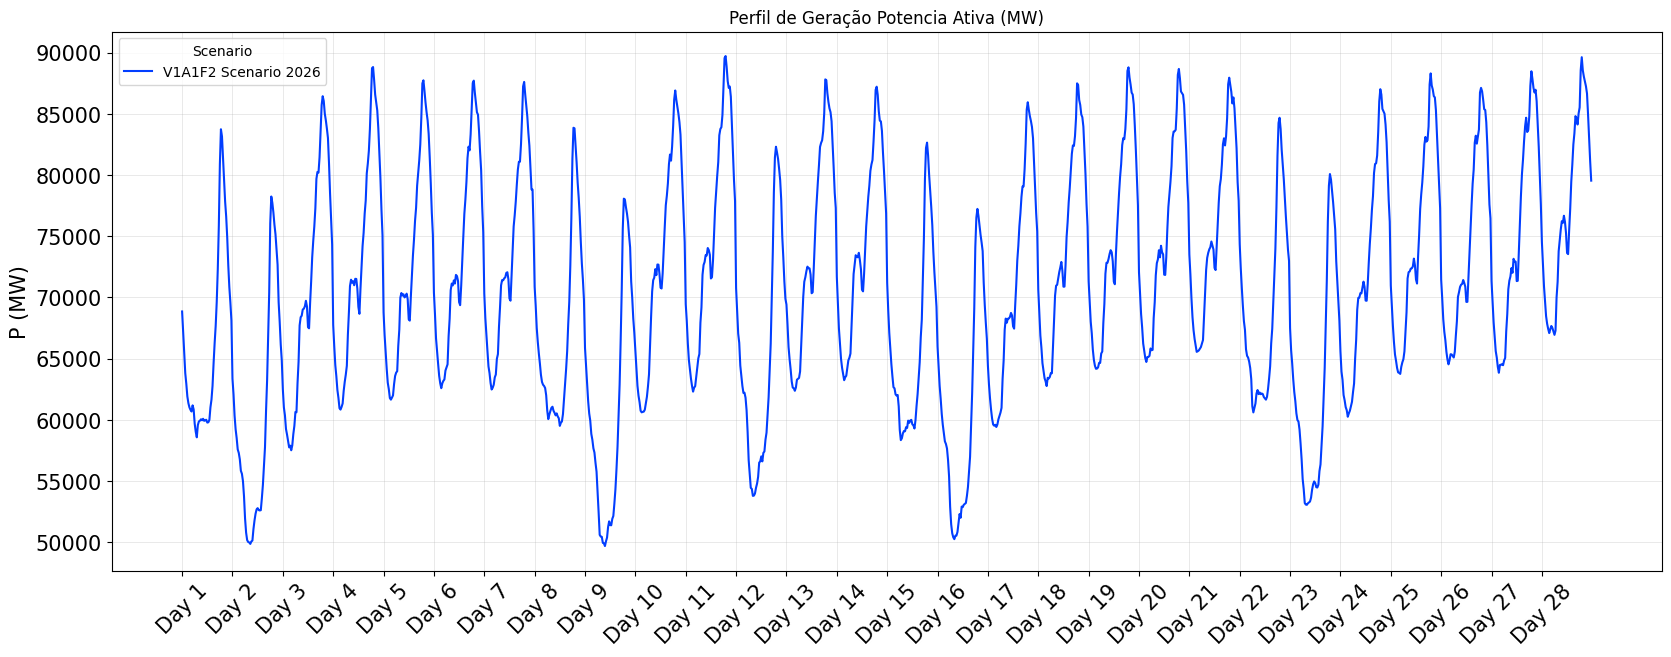

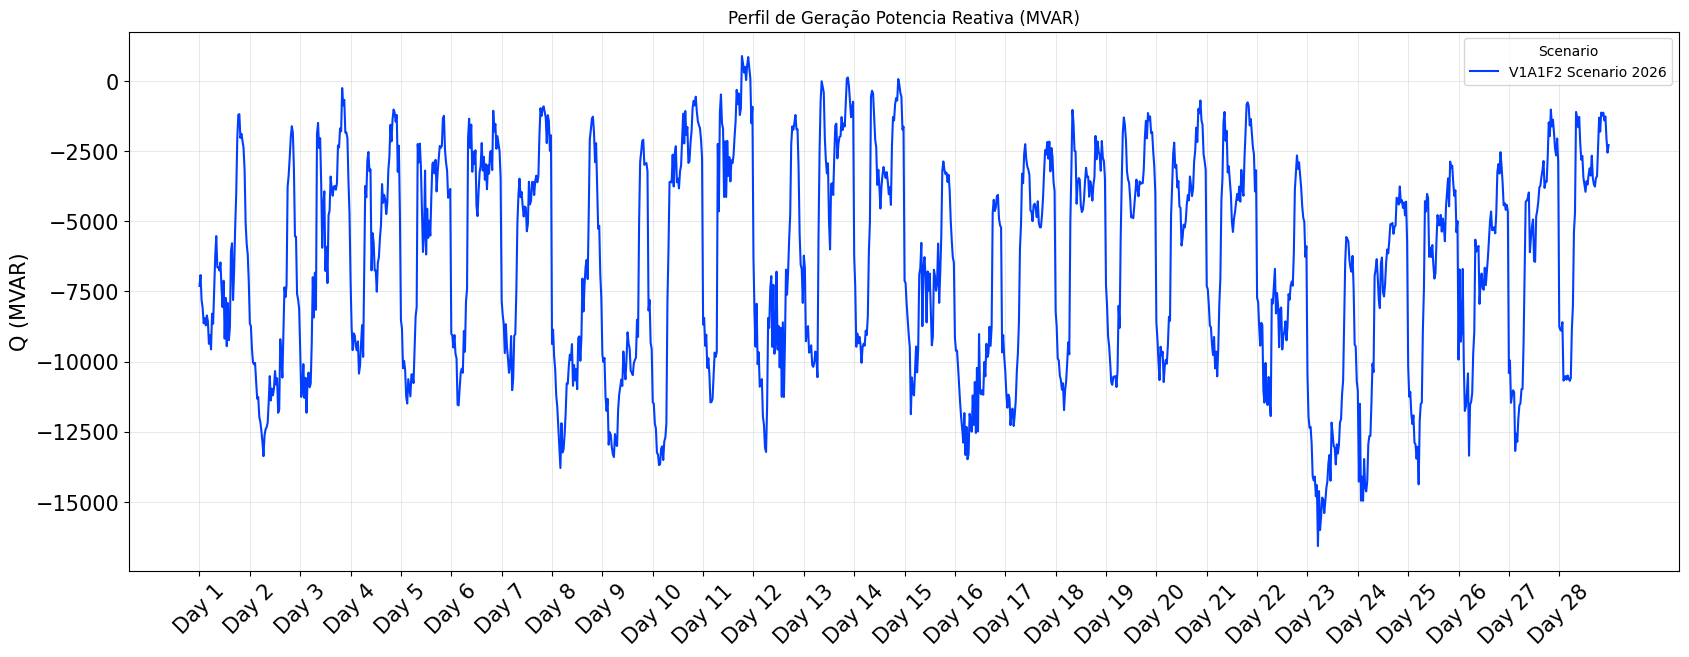

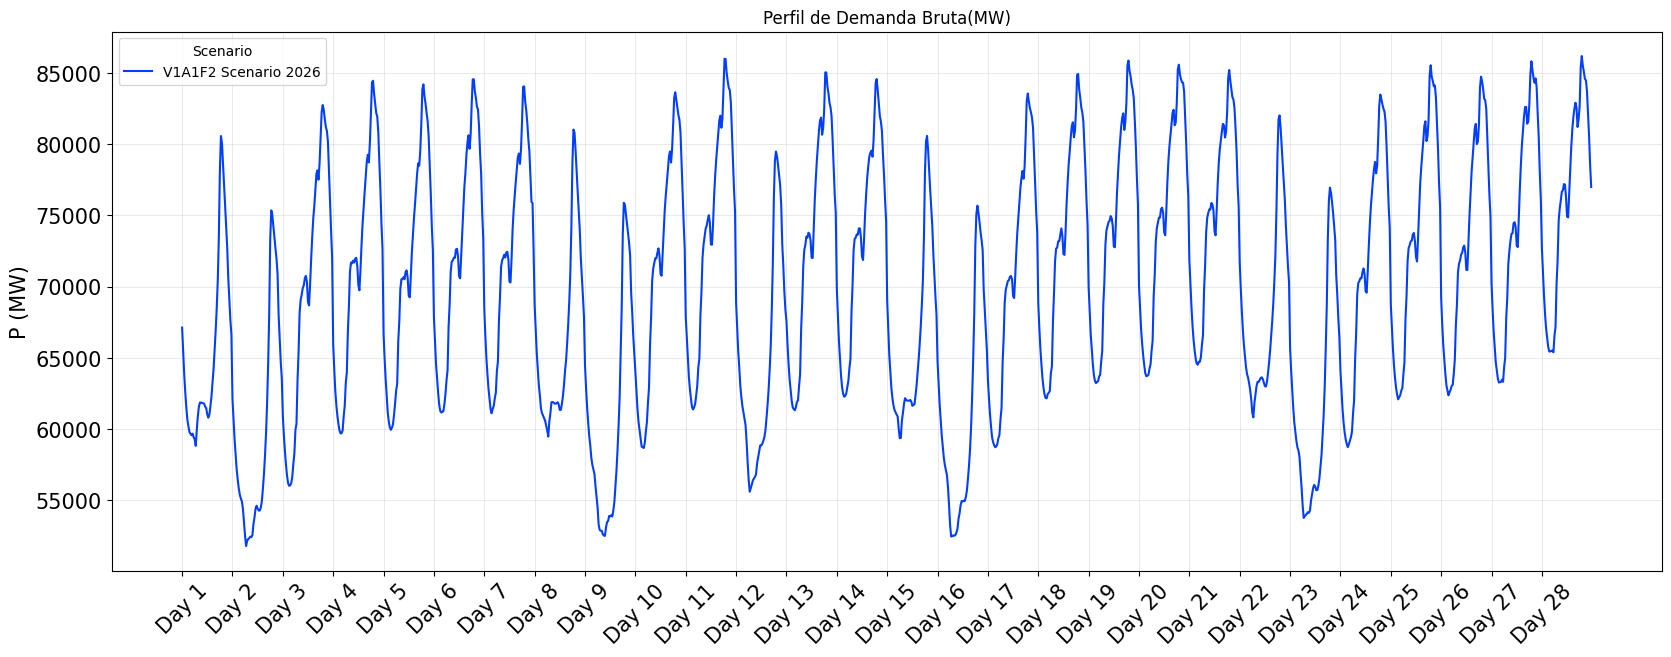

70753.41965773811


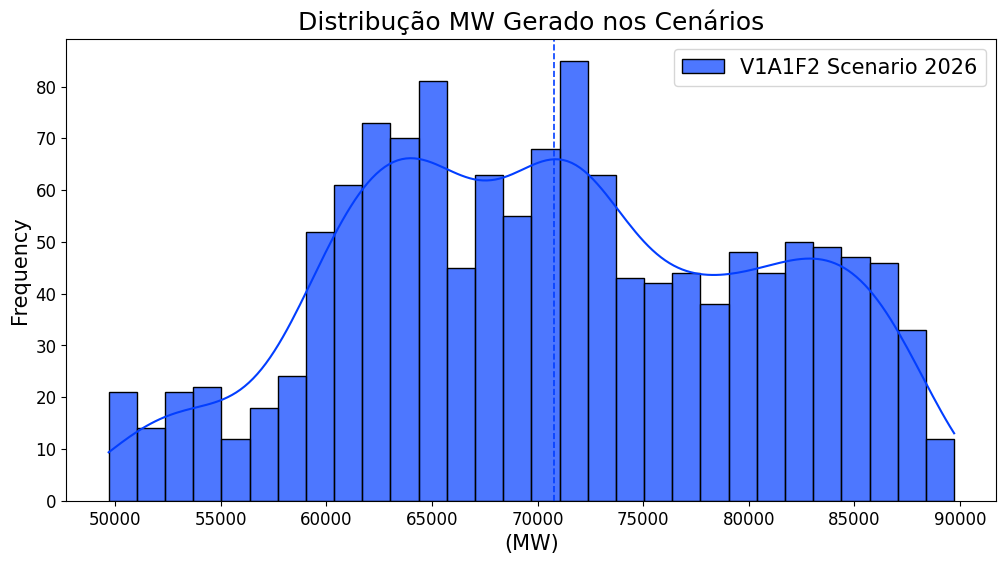

-6471.125723958334


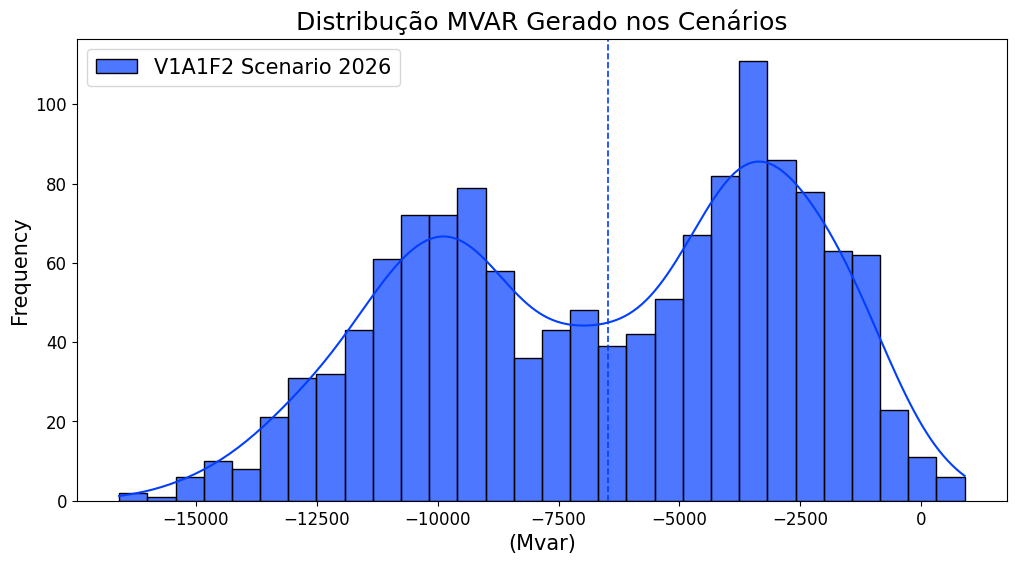

In [6]:
def plot_perfil_pot(df, columna, ylbl, titulo, ylim = None, day = False, variavel = None, otherplot = False):

    fig, ax = plt.subplots(figsize=(20, 7))
    for idx in range(len(df)):
        dff = df_mask.merge(df[idx], on=['Dia','Hora', 'Cenario'], how='left')
        if variavel == None:
            cenario = dff['Cenario'].iloc[0]
        else:
            cenario = dff[variavel].iloc[0]
        plt.plot(dff['Dia_Hora'], dff[columna], label=namescenarios[cenario][0], color=namescenarios[cenario][1])

    plt.legend(title='Scenario')
    plt.title(titulo)
    plt.xlabel('Operation Point',fontsize=15)
    plt.ylabel(ylbl, fontsize=15)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    if day:
        days = ['Day {}'.format(i+1) for i in range(28)]
        plt.xticks(ticks=[i*48 for i in range(28)], labels=days, rotation=45)
        plt.xlabel('',fontsize=10)
    plt.grid('-',lw = 0.4, alpha=0.50)
    if ylim != None:
        plt.ylim(ylim)
    if otherplot == False:
        plt.show()

def distribution_plot(df, columna, xlbl, titulo, variavel = None):

    plt.figure(figsize=(12, 6))
    for dff in df:
        if variavel == None:
            cenario = dff['Cenario'].iloc[0]
        else:
            cenario = dff[variavel].iloc[0]
        sns.histplot(dff[columna], kde=True, label=namescenarios[cenario][0], color=namescenarios[cenario][1], bins=30, multiple="stack",alpha=0.70, element='bars',)
        plt.axvline(dff[columna].mean(), color=namescenarios[cenario][1], linestyle='dashed', linewidth=1.2)
        print(dff[columna].mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.tick_params(axis='both', labelsize=12)
    plt.legend(loc='best', fontsize = 15)
    plt.show()


if Analise_Potencia:
    df_pot_mw_mvar_filt = filtarNC(dfs['pot_mw_mvar'])
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PG_MW', ylbl='P (MW)', titulo='Perfil de Geração Potencia Ativa (MW)', day=True)
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='QG_MVAR', ylbl='Q (MVAR)', titulo='Perfil de Geração Potencia Reativa (MVAR)', day=True)
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PL_MW', ylbl='P (MW)', titulo='Perfil de Demanda Bruta(MW)', day=True)
    
    distribution_plot(df_pot_mw_mvar_filt,'PG_MW', '(MW)', 'Distribução MW Gerado nos Cenários')
    distribution_plot(df_pot_mw_mvar_filt,'QG_MVAR', '(Mvar)', 'Distribução MVAR Gerado nos Cenários')
    
    if Analise_Reserva:
        df_mw_reserv = filtarNC(dfs['pot_mw_reserv'])
        distribution_plot(df_mw_reserv,' Reserve', 'Reserve (MW)', 'Distribução MW Reserva nos Cenários')
        df_pot_mvar_reserv = filtarNC(dfs['pot_mvar_reserv'])
        distribution_plot(df_pot_mvar_reserv,'ReservaIND', 'Reserve (MVVAR)', 'Distribução MVAR Reserva nos Cenários')
        distribution_plot(df_pot_mvar_reserv,'ReservaCAP', 'Reserve (MVVAR)', 'Distribução MVAR Reserva nos Cenários')

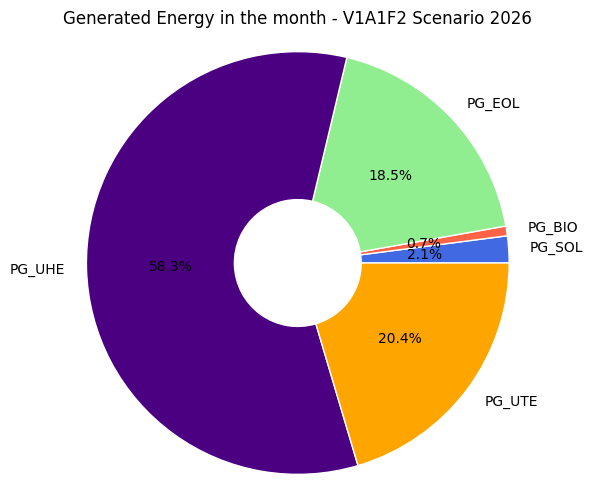

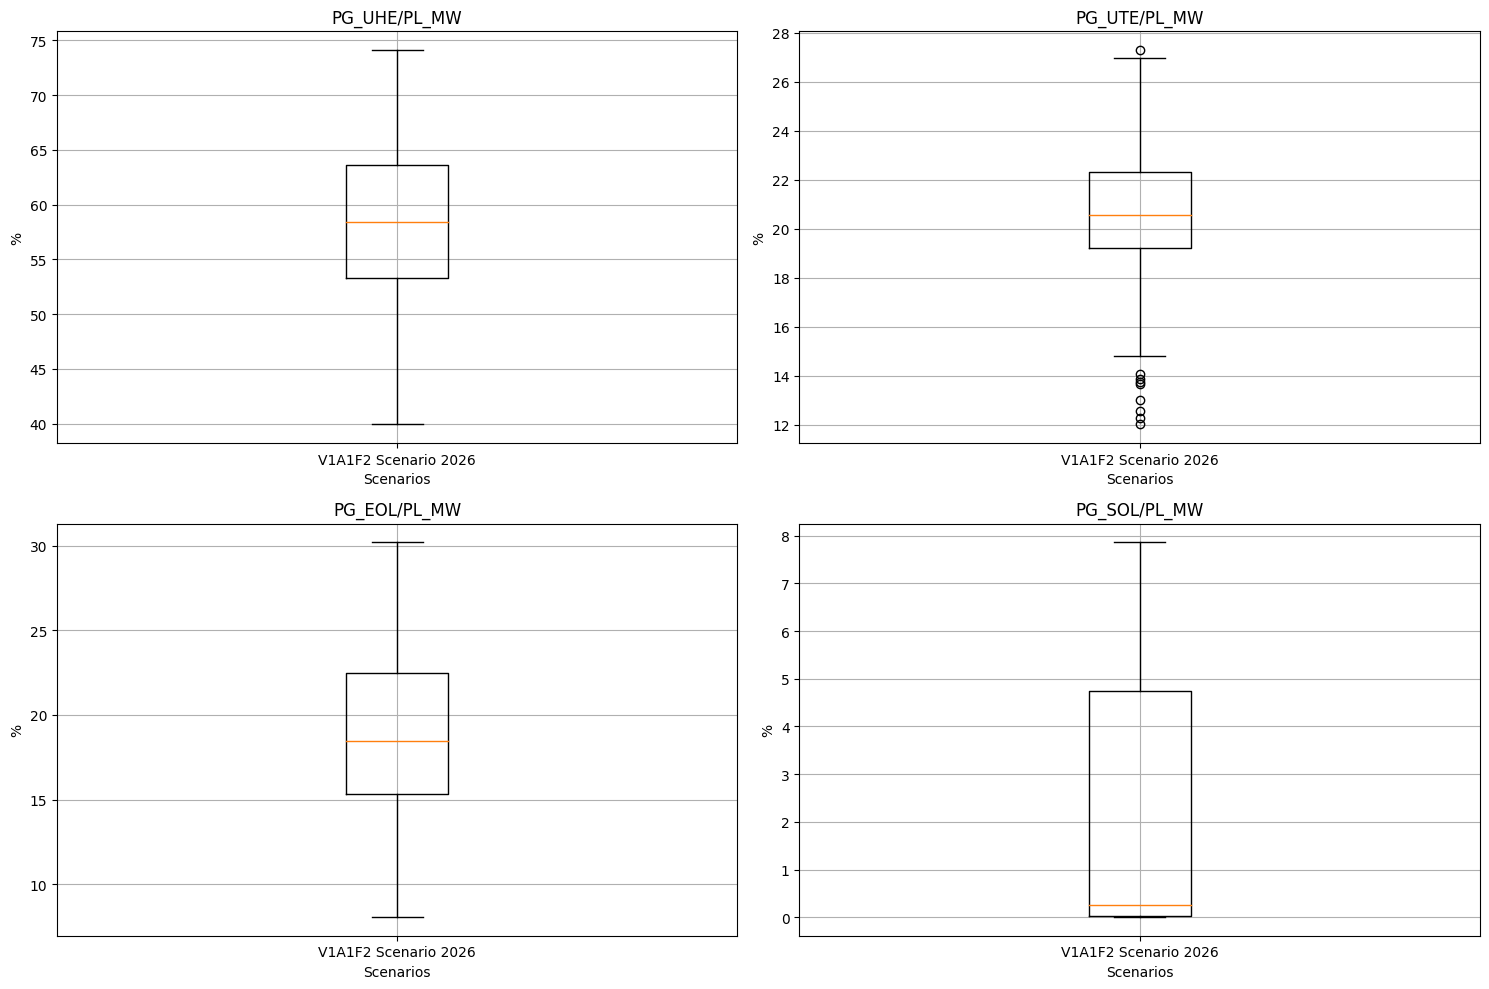

In [7]:
def stacklineplot (df, scenario):
    df.reset_index(inplace=True)
    traces = []
    cumulative_sum = 0
    for column in df.columns[2:]:  # Exclude 'Dia' and 'Hora' columns
        trace = go.Scatter(
            x=df.index,  # Assuming 'Hora' is the time column
            y=df[column] + cumulative_sum,
            mode='lines',
            name=column.split('_')[-1],  # Extract the power source name
            opacity=0.8,
            fill='tonexty',
            hoverinfo='x+y'  # Show both x and y values when hovering
        )
        traces.append(trace)
        cumulative_sum += df[column]

    # Create the plot
    fig = go.Figure(traces)
    fig.update_layout(
        title="Power Generation by Source for " + scenario,
        xaxis_title="Time",
        yaxis_title="Power Generation",
        legend_title="Power Source",
        plot_bgcolor='white',
        width=1200,  # Width of the figure in pixels
        height=600,  # Height of the figure in pixels
    )
    fig.show()

def pieplot(etiquetas, valores, explode, title):

    def custom_autopct(pct, valores):
        # return f"{pct:.1f}%\n({float(pct/100 * sum(valores)):.2f}TWh)"
        return f"{pct:.1f}%"
    
    colores = ["#4169E1", "#FF6347", "#90EE90", "#4B0082", "#FFA500", "#FFC0CB"]
    # Create the pie chart
    plt.figure(figsize=(6, 6))  # Adjust figure size
    plt.pie(valores, labels=etiquetas, colors=colores, autopct=lambda pct: custom_autopct(pct, valores), explode=explode,
            wedgeprops=dict(width=0.7, edgecolor='w'))  # Adjust slice width and edge color

    # Title and Legend
    plt.title("Generated Energy in the month - " + title, fontsize=12)  # Customize title
    # plt.legend(etiquetas, loc="best")
    plt.axis('equal')  # Equal aspect ratio ensures a circular chart
    # Display the chart
    plt.show()

if Analise_GenbySource:

    DFF_POT = DATA['df_ger_reg_concat'].drop(columns='REG').groupby(by=['Dia', 'Hora', 'Cenario']).sum()
    DFF_POT_REG = DATA['df_ger_reg_concat'].set_index(['Dia','Hora','REG','Cenario'])
    for scenario in dic_cenarios.keys():
        objt = DFF_POT.loc[:,:,scenario][['PG_SOL','PG_BIO','PG_EOL','PG_UHE', 'PG_UTE',]].sum()*0.5 #/1000000TWh
        labels = objt.index
        values = objt.values
        data_ = DFF_POT.loc[:,:,scenario][['PG_UHE', 'PG_UTE', 'PG_SOL','PG_BIO','PG_EOL',]]
        pieplot(labels,values, (0, 0, 0.0, 0, 0), scenario)
        stacklineplot (data_, scenario)


    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    for idx, column in enumerate(['PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']):
        data_to_plot = []
        for scenario in dic_cenarios.keys():
            dff = DFF_POT.loc[:, :, scenario]
            data_to_plot.append(dff[column] / dff['PL_MW']*100)
        ax = axes[idx//2, idx%2]
        ax.boxplot(data_to_plot, labels=dic_cenarios.keys())
        ax.set_title(f"{column}/PL_MW")
        ax.set_xlabel("Scenarios")
        ax.set_ylabel('%')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

<Figure size 2000x700 with 0 Axes>

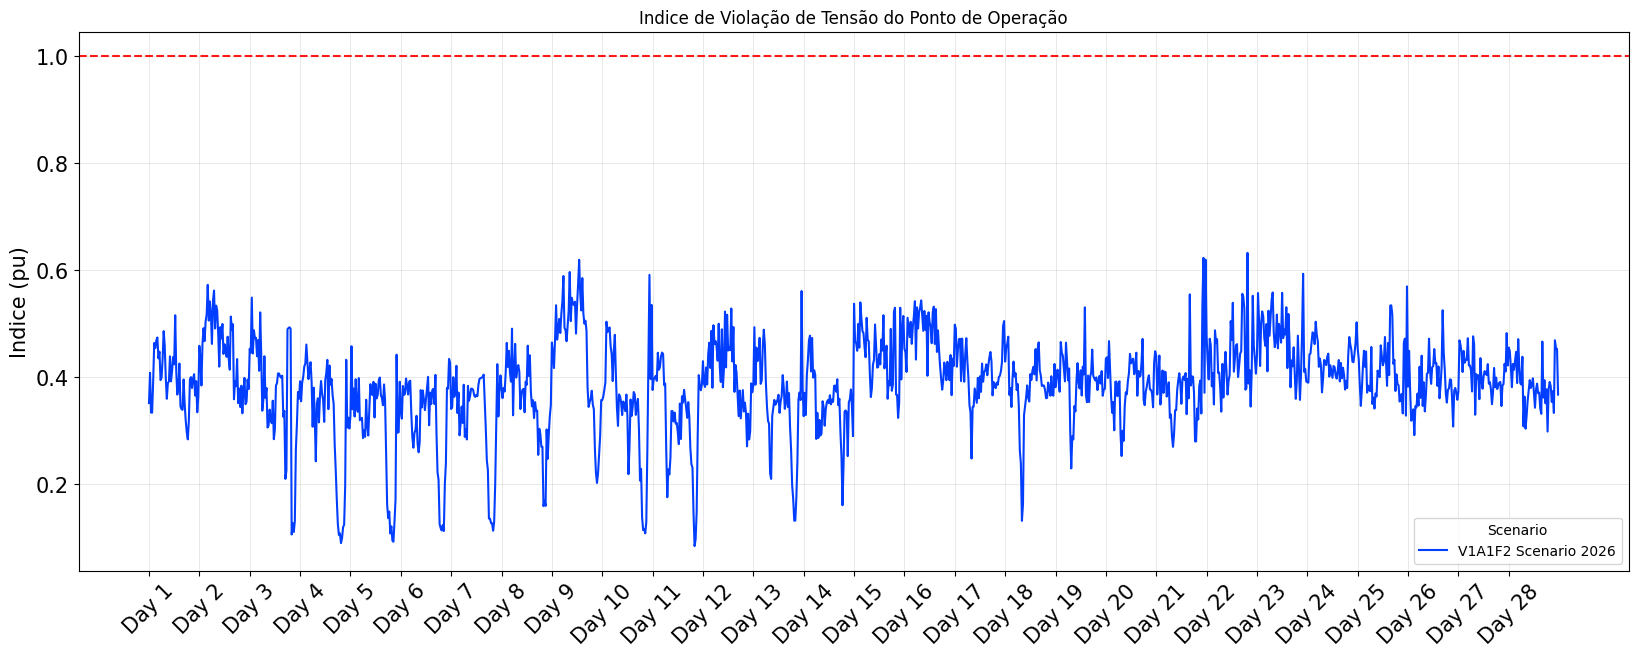

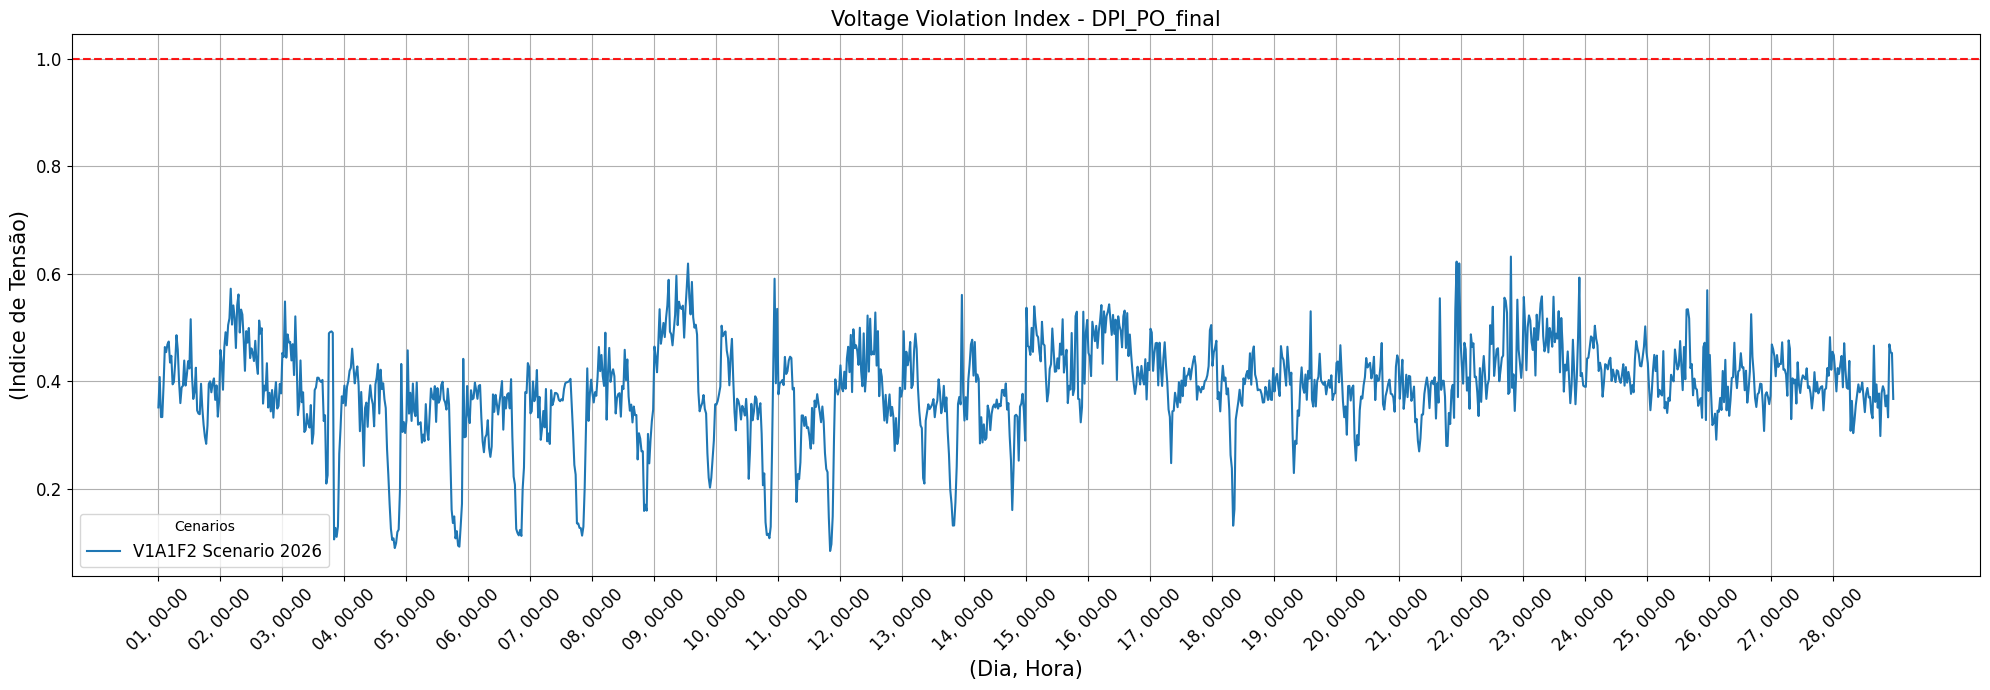

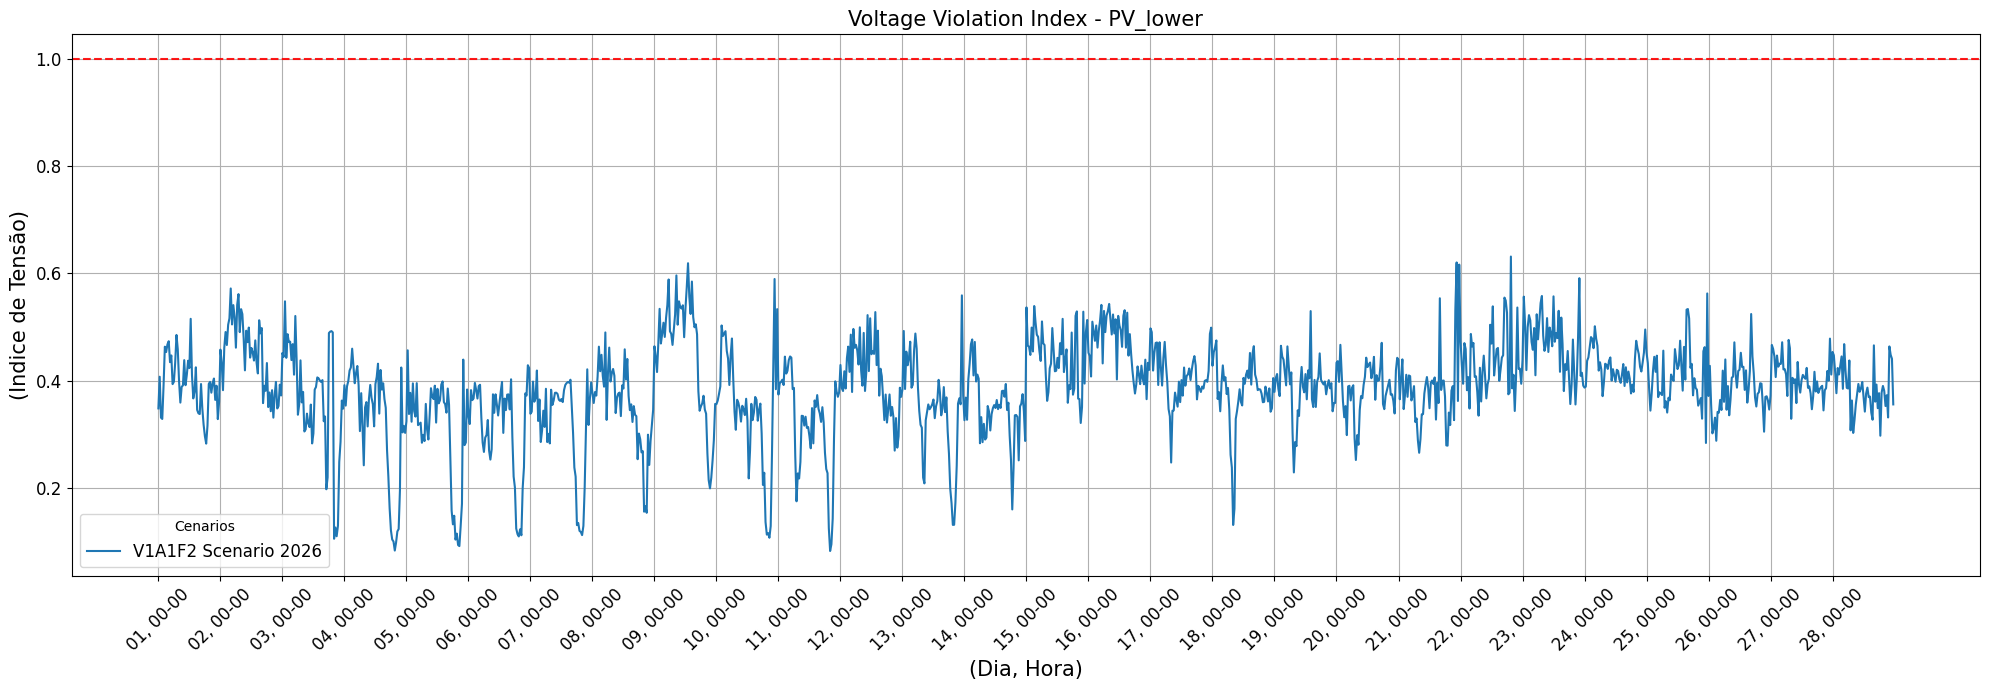

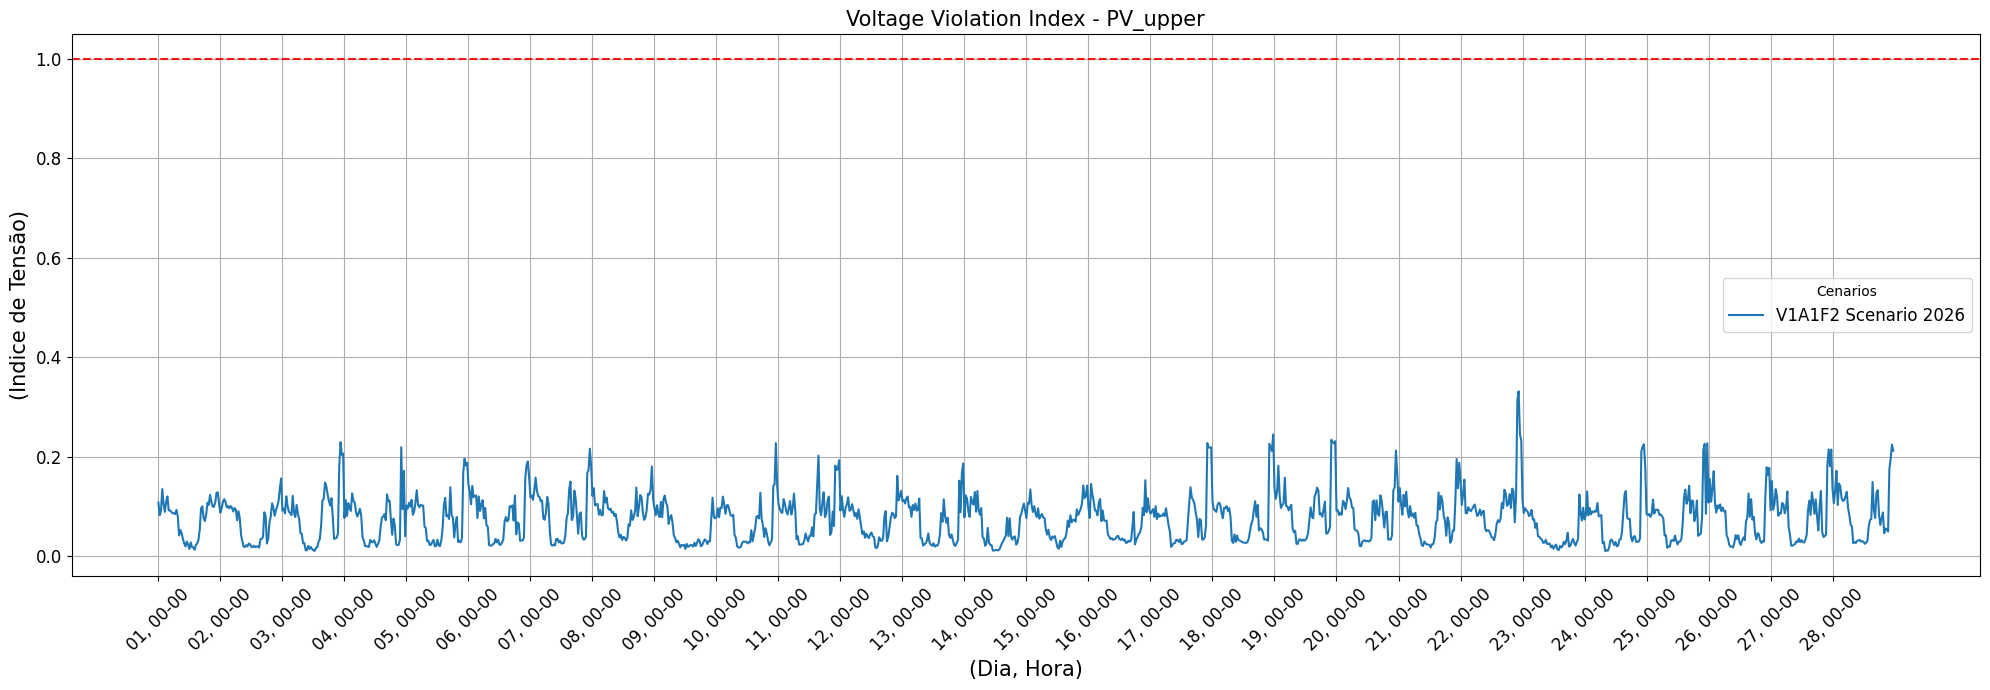

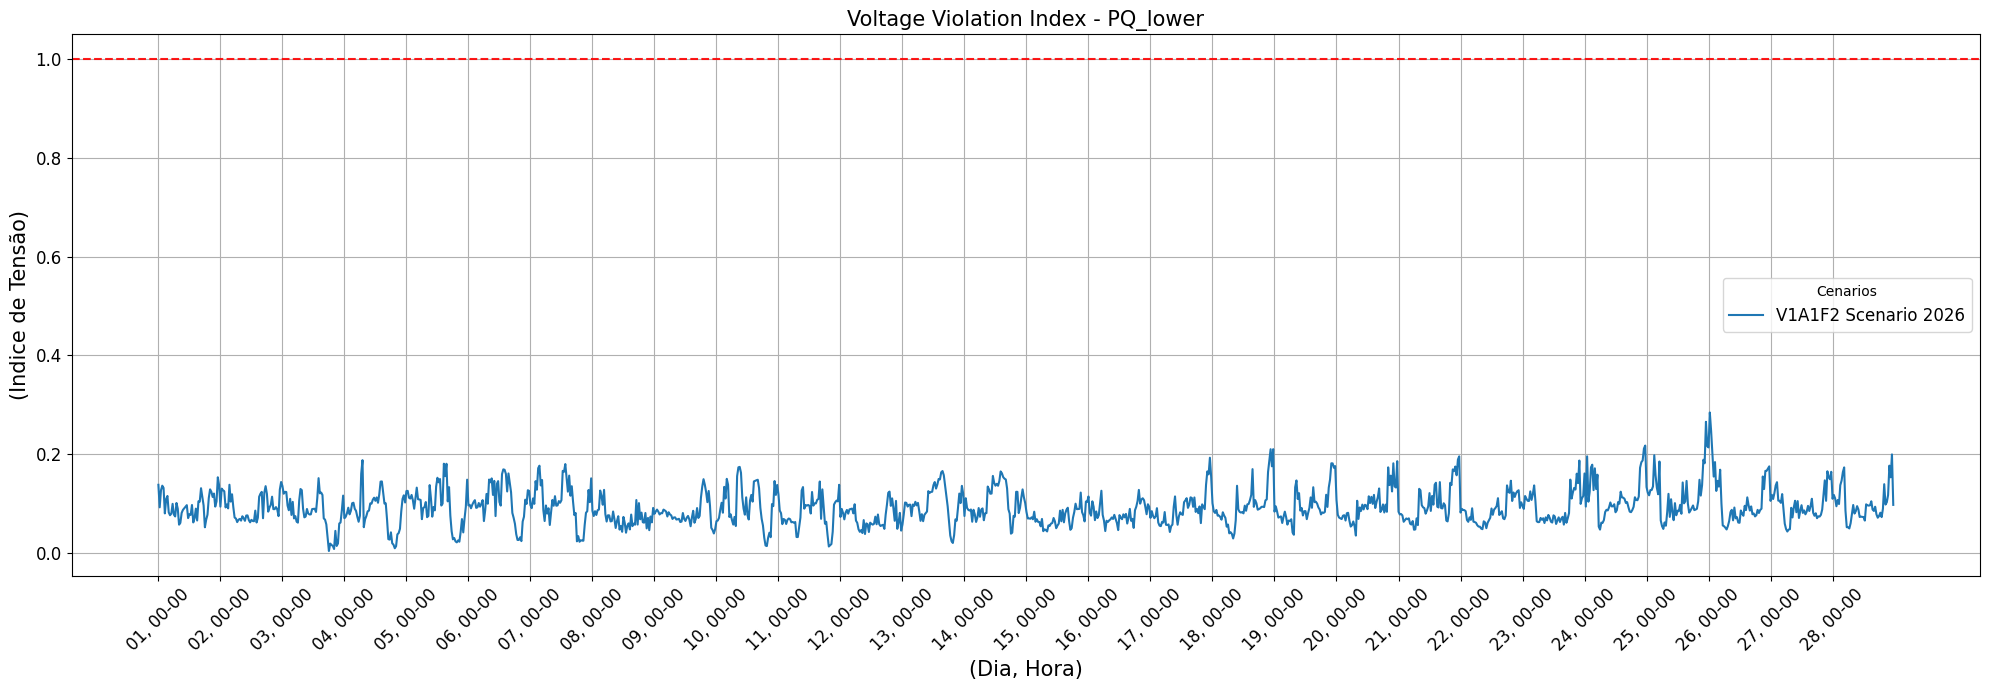

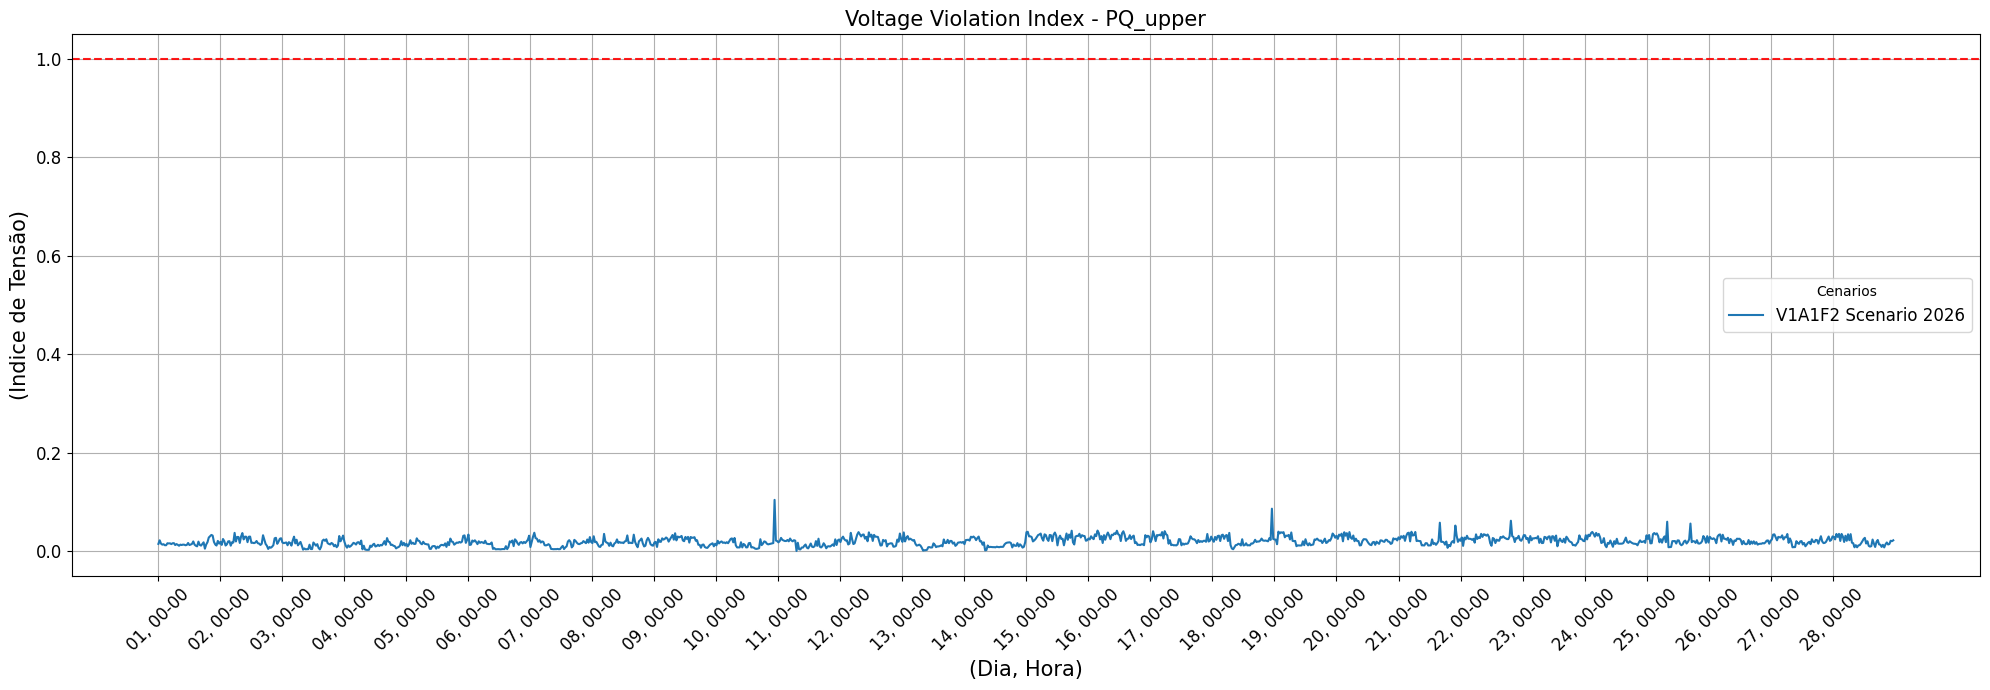

In [8]:
def plot_indice_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

    df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
    df = df[['Dia_Hora','Cenario' ,  column]]

    # Plotting
    plt.figure(figsize=(20, 7))
    # sns.lineplot(data=F_ONS_melted, x='Dia_Hora', y='value', hue='Fluxos', style='Fluxos', markers=True)
    sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', style='Cenario', markers=markers)
    plt.xlabel('(Dia, Hora)', fontsize = 15)
    plt.ylabel('(Indice de Tensão)', fontsize = 15)
    plt.title(f'Voltage Violation Index - {column}', fontsize = 15)

    value = int(df['Dia_Hora'].unique().shape[0]/(28))
    selected_ticks = df['Dia_Hora'].iloc[::value]  # Change the step value as needed

    plt.xticks(selected_ticks, rotation=45, fontsize=12)
    plt.tick_params(axis='y', labelsize=12)
    # plt.xlim(selected_ticks.iloc[0], selected_ticks.iloc[-1])
    plt.legend(title='Cenarios', fontsize = 12)
    # Agregar la línea horizontal en el valor cero del eje y
    plt.axhline(1, color='red', linestyle='--' ,  alpha=0.9)
    if ylim != None:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.grid()
    plt.show()

if Analise_Tensão:
    plt.figure(figsize=(20, 7))
    plot_perfil_pot(dfs['Index_PO'], columna='DPI_PO_final', ylbl='Indice (pu)', titulo='Indice de Violação de Tensão do Ponto de Operação', day=True, otherplot=True)
    plt.axhline(1, color='red', linestyle='--' ,  alpha=0.9)
    plt.show()
    plot_indice_perfil(df_mask, pd.concat(dfs['Index_PO'], axis=0), 'DPI_PO_final',markers=False)
    for column in DATA['df_indice_group'].columns:
        plot_indice_perfil(df_mask, DATA['df_indice_group'], column, markers=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


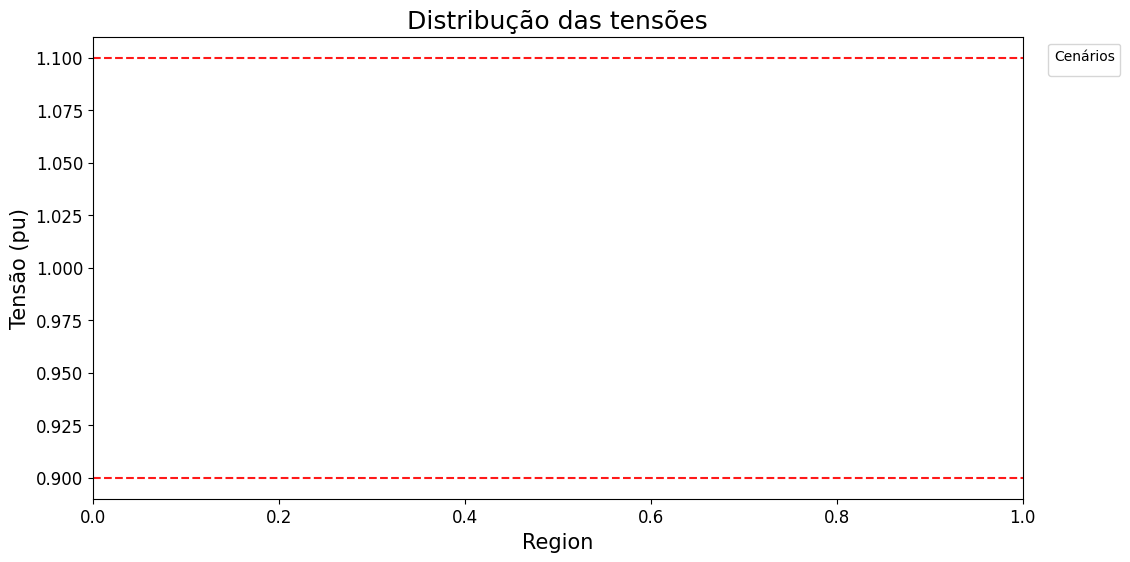

In [9]:
def boxplot_voltage(df, clase, titulo, xlbl, ylim = None):

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=clase, y="MODV_PU", hue="Cenario", width=.9, linewidth=1, gap=.1, palette = "Set1")
    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('Tensão (pu)', fontsize=15)
    plt.tick_params(axis='both', labelsize=12)
    plt.legend(title='Cenários', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.axhline(1.10, color='red', linestyle='--' ,  alpha=0.9)
    plt.axhline(0.90, color='red', linestyle='--' ,  alpha=0.9)
    if ylim !=  None:
        plt.ylim(ylim)
    plt.show()

mask_inseguros = DATA['df_indice_group'][(DATA['df_indice_group']['PV_upper']>1) | (DATA['df_indice_group']['PV_upper']>1) | (DATA['df_indice_group']['PQ_lower']>1) | (DATA['df_indice_group']['PQ_upper']>1)]
df_ger = pd.concat(dfs['ger'], axis=0)
df_nt = pd.concat(dfs['nt'], axis=0)

filtro1 = (df_ger[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(mask_inseguros.index))
df_filt_ger = df_ger[filtro1]
filtro2 = (df_nt[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(mask_inseguros.index))
df_filt_nt = df_nt[filtro2]
df_complete = pd.concat([df_filt_nt, df_filt_ger], axis=0)

boxplot_voltage(df_complete, clase = "REG", titulo = 'Distribução das tensões', xlbl = 'Region')

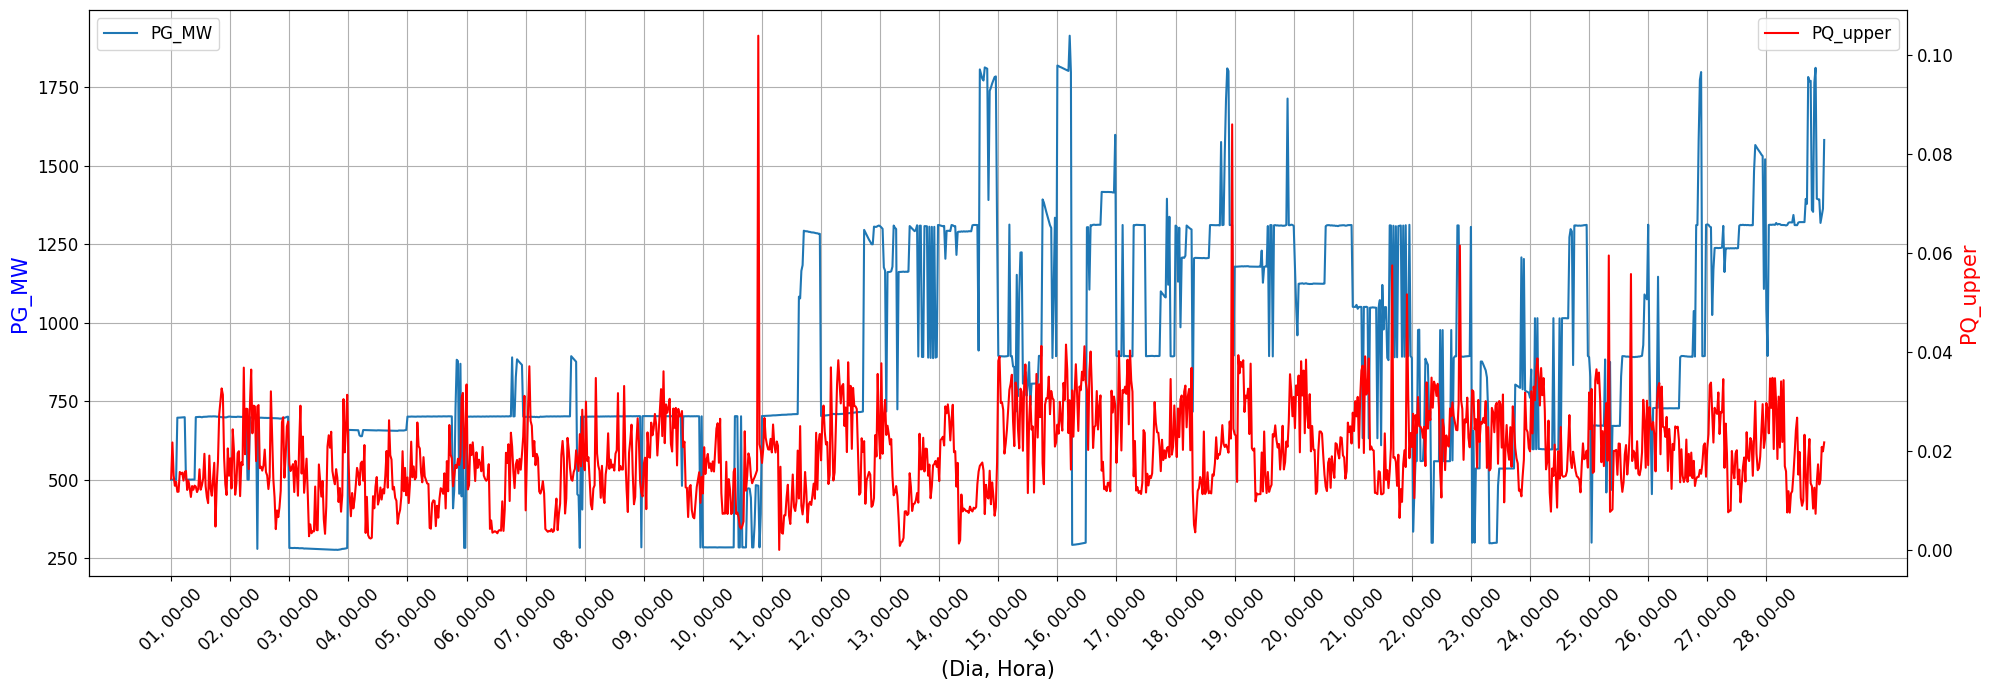

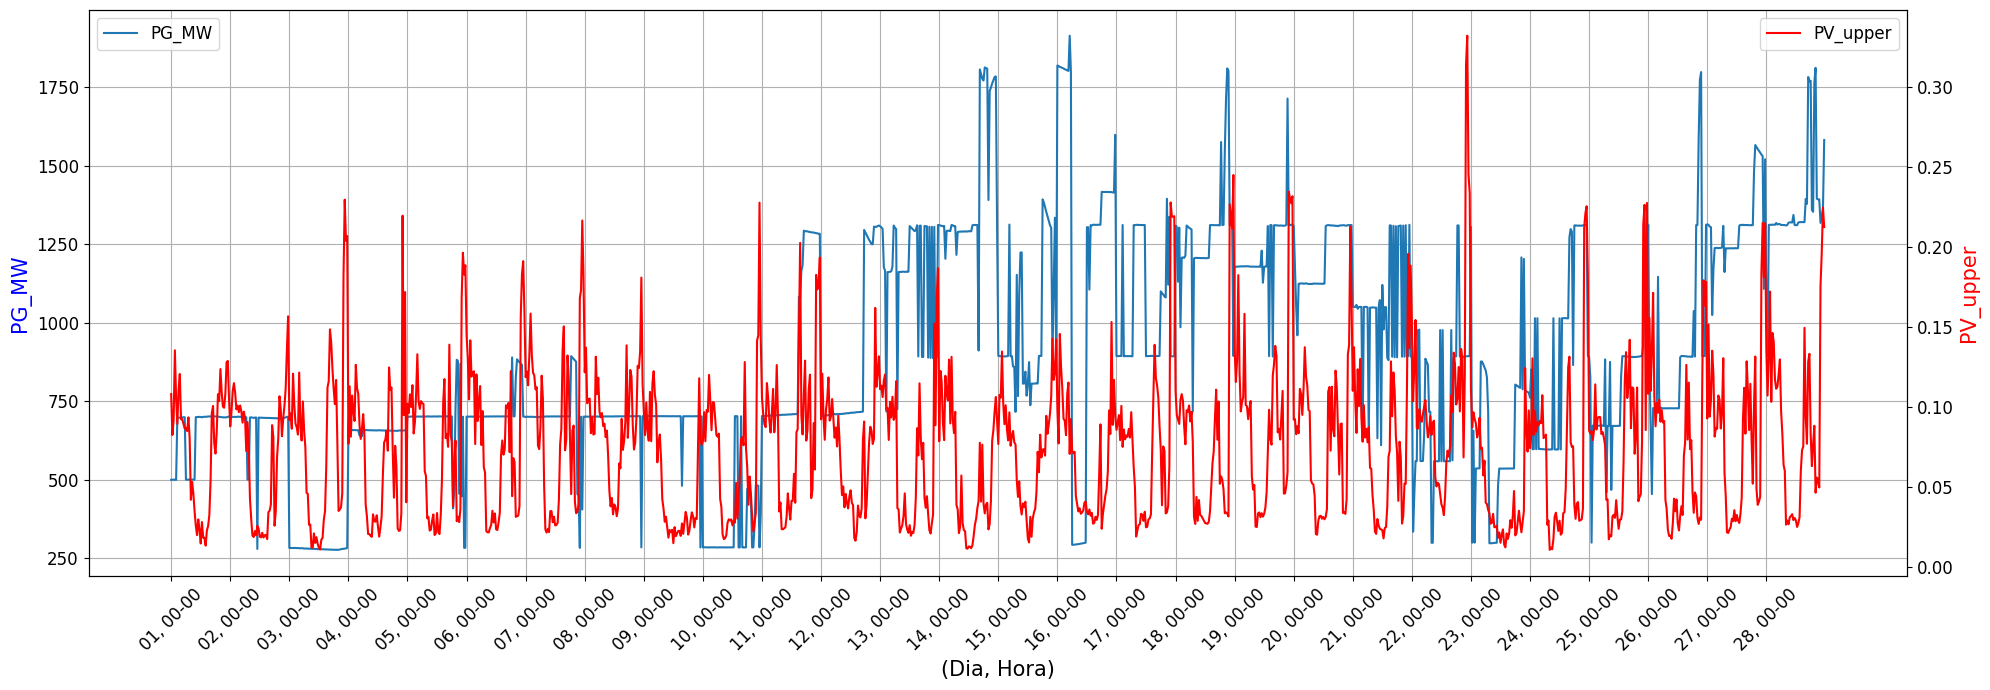

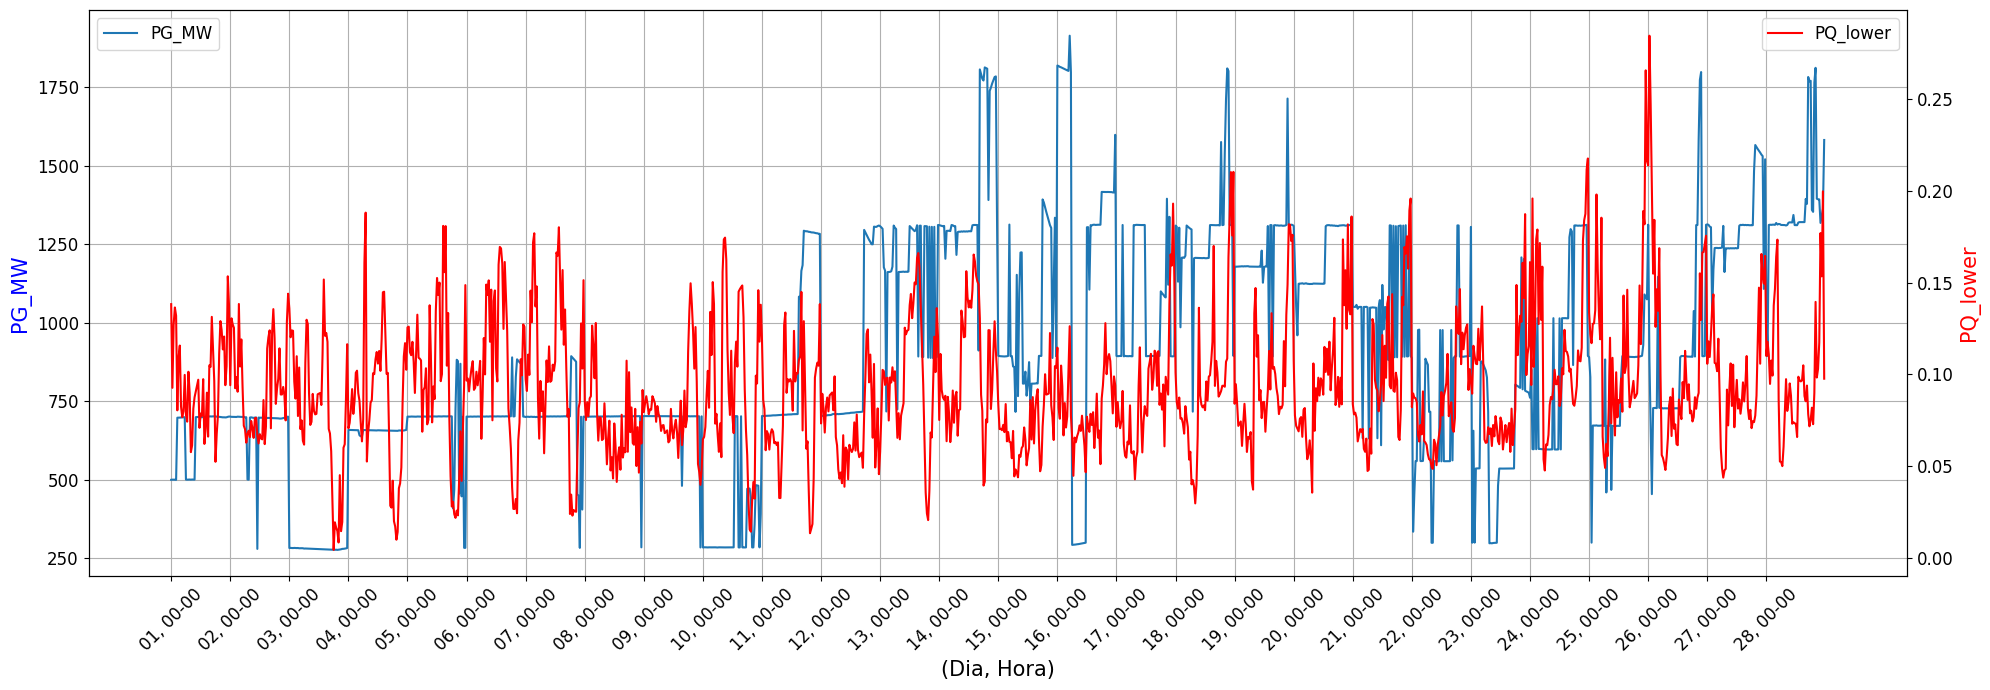

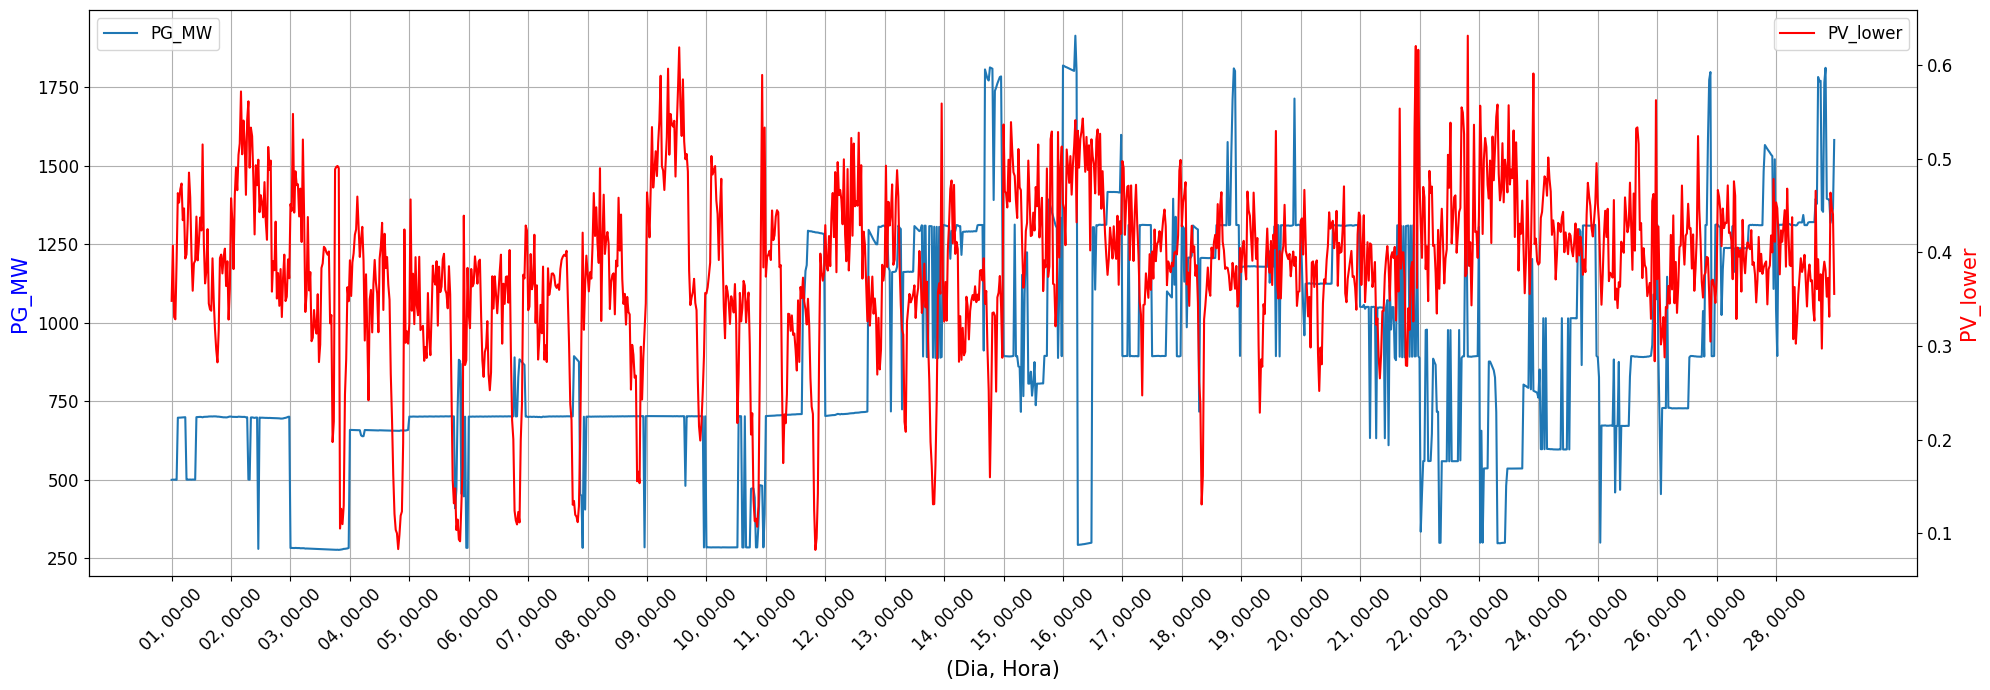

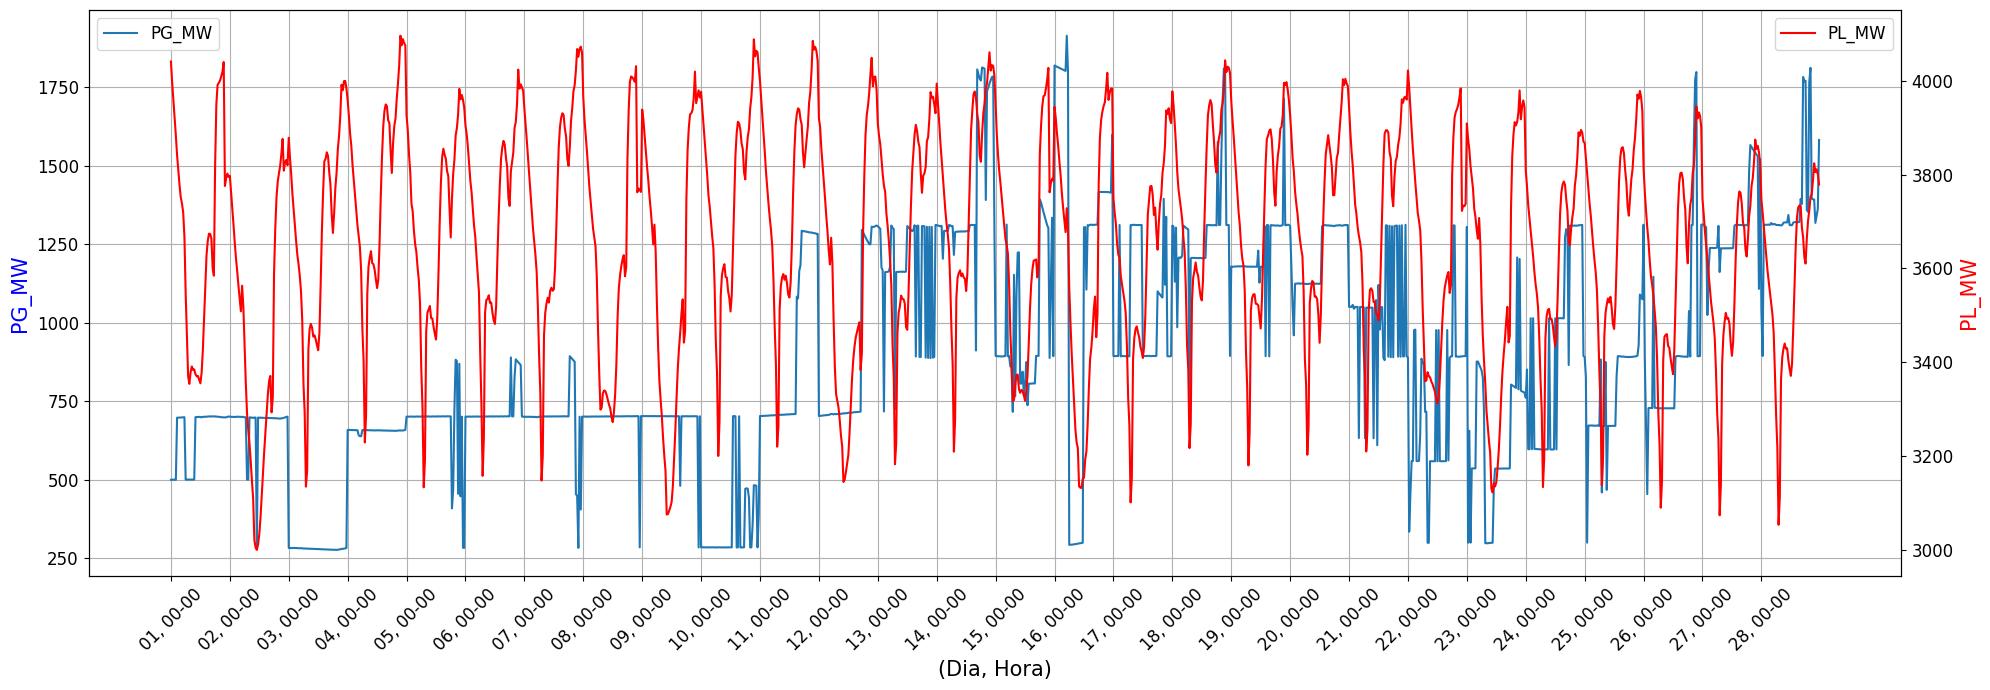

In [10]:
def plot_potencia_perfil_2(df_resultado, df_data, column1, column2, ylim=None, ylim2=None, markers=True):

    df = df_resultado.merge(df_data, on=['Dia','Hora', 'Cenario'], how='left')
    plt.figure(figsize=(20, 7))
    ax1 = plt.gca()  # get current axes
    sns.lineplot(data=df, x='Dia_Hora', y=column1, ax=ax1, label = column1)
    # sns.lineplot(data=df, x='Dia_Hora', y=column1, hue='Cenario', style='Cenario', markers=markers, label = column1)
    plt.xlabel('(Dia, Hora)', fontsize=15)
    plt.ylabel(column1, fontsize=15, color =  'blue')
    value = int(df['Dia_Hora'].unique().shape[0] / 28)
    selected_ticks = df['Dia_Hora'].iloc[::value]  # Change the step value as needed
    plt.xticks(selected_ticks, rotation=45, fontsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(alpha = 1)
    if ylim is not None:
        plt.ylim(ylim)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # Assuming you have another column named 'another_column' in df_data dataframe
    sns.lineplot(data=df, x='Dia_Hora', y=column2, ax=ax2, color='red', label = column2)  
    # sns.lineplot(data=df, x='Dia_Hora', y=column2, hue='Cenario', style='Cenario', markers=markers, label = column2)
    ax2.set_ylabel(column2, fontsize=15, color =  'red')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelsize=12)
    plt.legend(loc='upper right', fontsize=12)
    # plt.grid(axis='y', alpha = 0.5)
    if ylim2 is not None:
        plt.ylim(ylim2)

    plt.tight_layout()
    plt.show()

eloFozibiuna = [85, 86]
eloPVelArarq = [7055, 7057]
eloCPVbtbPvel = [7059, 7054]
eloXinguTR = [8100, 9605]
eloXinguESTR = [8100, 3010]
Jirau = [7051, 7061]
S_Antonio = [7050, 7062, 7064]
df_complete_t = pd.concat([df_nt, df_ger], axis=0)

region_ = 'Norte'
buses = S_Antonio
var = ['PG_MW']
if buses != None:
    dff_1 = df_complete_t[df_complete_t['BUS_ID'].isin(buses)]
elif buses == None:
    dff_1 = df_complete_t

dff_2 = dff_1.groupby(by=['Dia','Hora','Cenario'])[var].sum()
if region_ == 'ALL':
    dff_3 = df_complete_t.groupby(by=['Dia','Hora','Cenario'])[['PL_MW', 'QL_MVAR', 'B0_MVAR']].sum()
else:
    dff_3 = df_complete_t[(df_complete_t['REG']==region_)].groupby(by=['Dia','Hora','Cenario'])[['PL_MW', 'QL_MVAR', 'B0_MVAR']].sum()

dff_4 = dff_2.merge(dff_3, on=['Dia', 'Hora', 'Cenario'], how='left')
dff_5 = dff_4.merge(DATA['df_indice_group'], on=['Dia', 'Hora', 'Cenario'], how='left')
DFF5 = dff_5.reset_index()
plot_potencia_perfil_2(df_mask, DFF5[DFF5['Cenario']==DFF5['Cenario'].unique()[0]], 'PG_MW','PQ_upper', markers=False)
plot_potencia_perfil_2(df_mask, DFF5[DFF5['Cenario']==DFF5['Cenario'].unique()[0]], 'PG_MW','PV_upper', markers=False)
plot_potencia_perfil_2(df_mask, DFF5[DFF5['Cenario']==DFF5['Cenario'].unique()[0]], 'PG_MW','PQ_lower', markers=False)
plot_potencia_perfil_2(df_mask, DFF5[DFF5['Cenario']==DFF5['Cenario'].unique()[0]], 'PG_MW','PV_lower', markers=False)
plot_potencia_perfil_2(df_mask, DFF5[DFF5['Cenario']==DFF5['Cenario'].unique()[0]], 'PG_MW','PL_MW', markers=False)

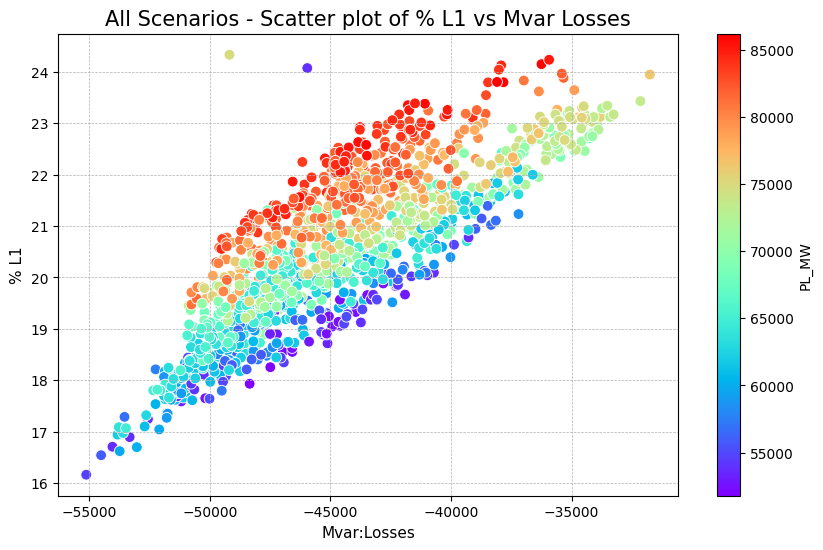

Indice de Correlación: 0.8268412111366281


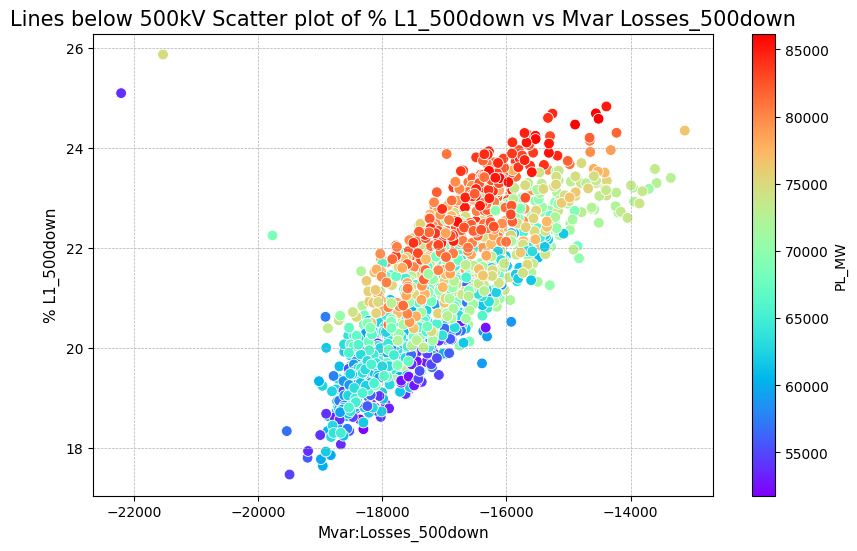

Indice de Correlación: 0.7638816659889466


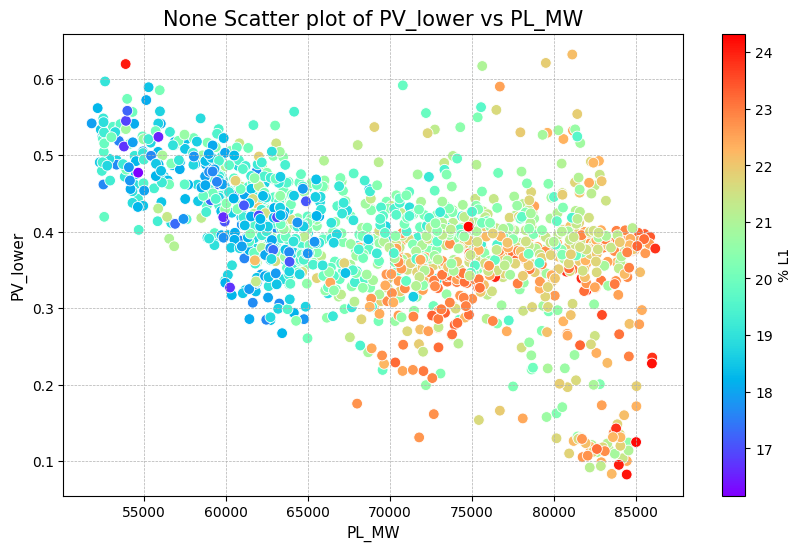

Indice de Correlación: -0.5038588397142928


In [11]:
def scatterplot(df, v1, v2,v3 = None, xlimites = None, namedir = None):

    plt.figure(figsize=(10, 6))
    if v3 == None:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, palette='rainbow', hue=v3, s=60, legend=None)
        norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
        sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label=v3)

    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    nometitulo = f'{namedir} Scatter plot of {v2} vs {v1}'.replace(':',' ')
    plt.title(nometitulo, fontsize = 15)
    plt.xlabel(v1, fontsize = 11)
    plt.ylabel(v2, fontsize = 11)
    if xlimites != None:
        plt.xlim(xlimites)
        
    # if namedir != None:
        # nome = folderimg+'Correlações/' + namedir + nometitulo + '.svg'
        # # plt.savefig(nome)
        # nome = folderimg+'Correlações/' + namedir + nometitulo + '.png'
        # # plt.savefig(nome)
    plt.show()

    correlation = df[v1].corr(df[v2])
    print(f"Indice de Correlación: {correlation}")

scatterplot(DF_complete_PO, 'Mvar:Losses', '% L1', 'PL_MW',namedir='All Scenarios -')
scatterplot(DF_complete_PO, 'Mvar:Losses_500down', '% L1_500down', 'PL_MW', namedir ='Lines below 500kV')
scatterplot(DF_complete_PO, 'PL_MW', 'PV_lower', '% L1')

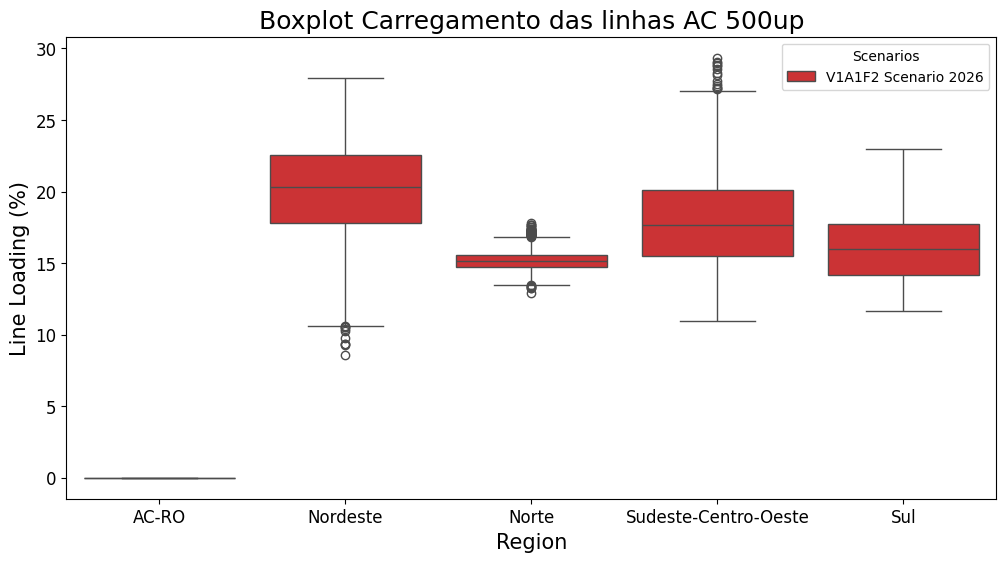

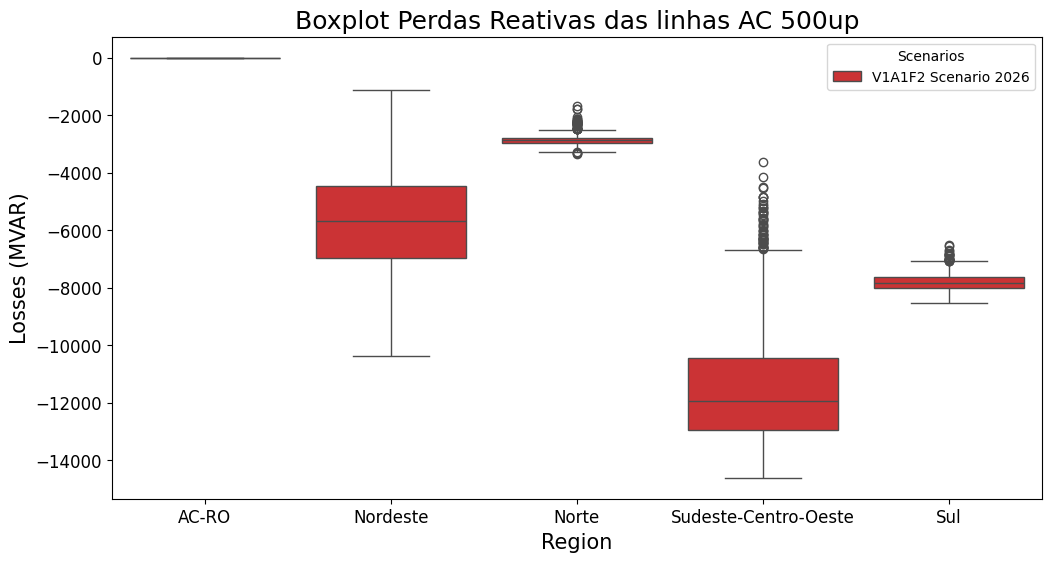

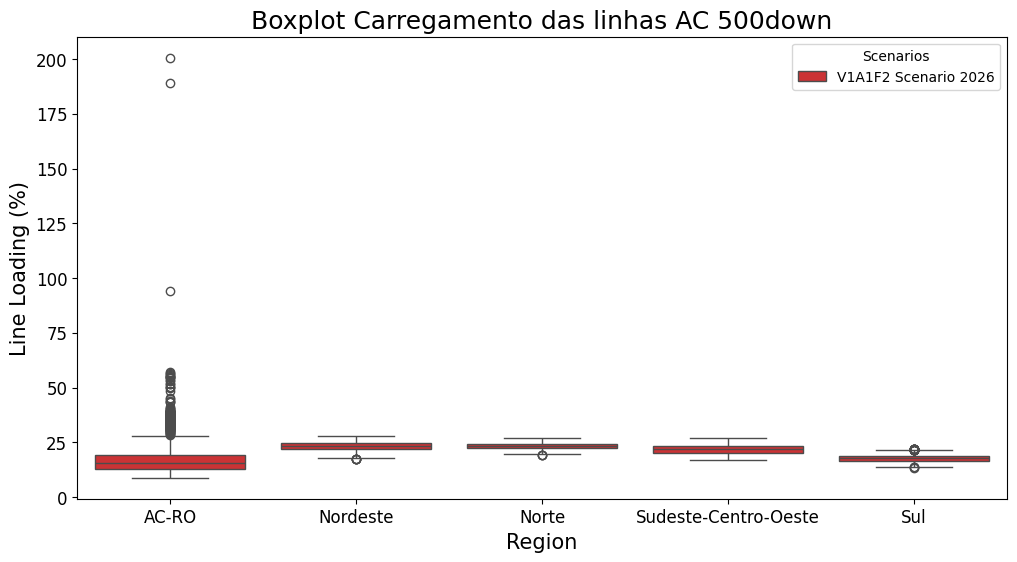

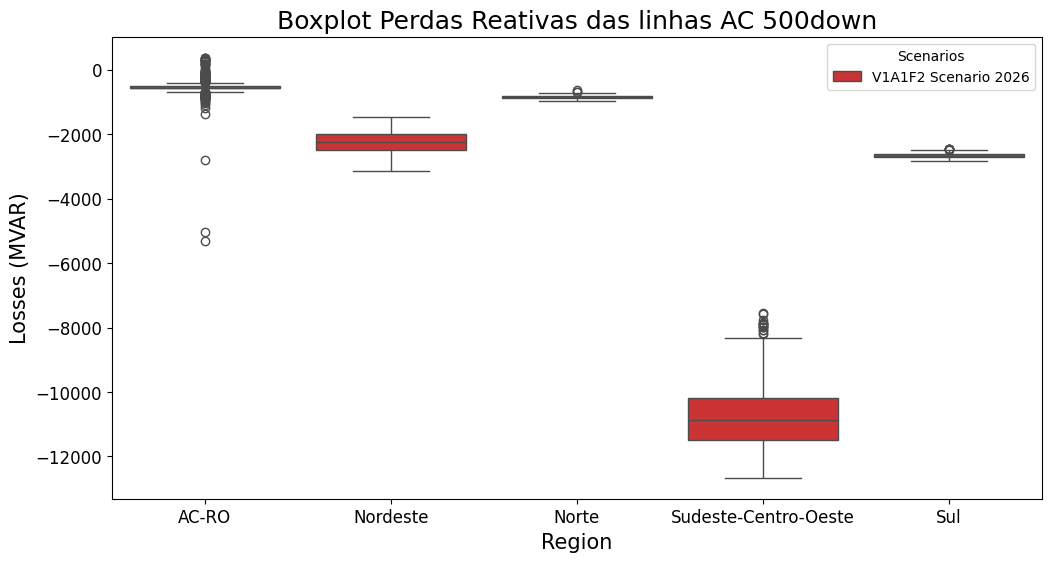

In [12]:
def boxplot_linhas(df, clase, yvalue, titulo, xlbl, ylbl, ylim = None):
    df = df.reset_index()
    plt.figure(figsize=(12, 6))
    boxplot = sns.boxplot(data=df, x=clase, y=yvalue, hue="Cenario", width=.9, linewidth=1, gap=.1, palette = "Set1")
    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel(ylbl, fontsize=15)
    plt.tick_params(axis='both', labelsize=12)
    plt.legend(title='Scenarios', loc='best')
    if ylim !=  None:
        plt.ylim(ylim)
    plt.show()
    
if Analise_Linhas:
    boxplot_linhas(Df_data_completo_reg, 'REG', '% L1_500up' , 'Boxplot Carregamento das linhas AC 500up', 'Region', 'Line Loading (%)', ylim = None)
    boxplot_linhas(Df_data_completo_reg, 'REG', 'Mvar:Losses_500up' , 'Boxplot Perdas Reativas das linhas AC 500up', 'Region', 'Losses (MVAR)', ylim = None)
    boxplot_linhas(Df_data_completo_reg, 'REG', '% L1_500down' , 'Boxplot Carregamento das linhas AC 500down', 'Region', 'Line Loading (%)', ylim = None)
    boxplot_linhas(Df_data_completo_reg, 'REG', 'Mvar:Losses_500down' , 'Boxplot Perdas Reativas das linhas AC 500down', 'Region', 'Losses (MVAR)', ylim = None)

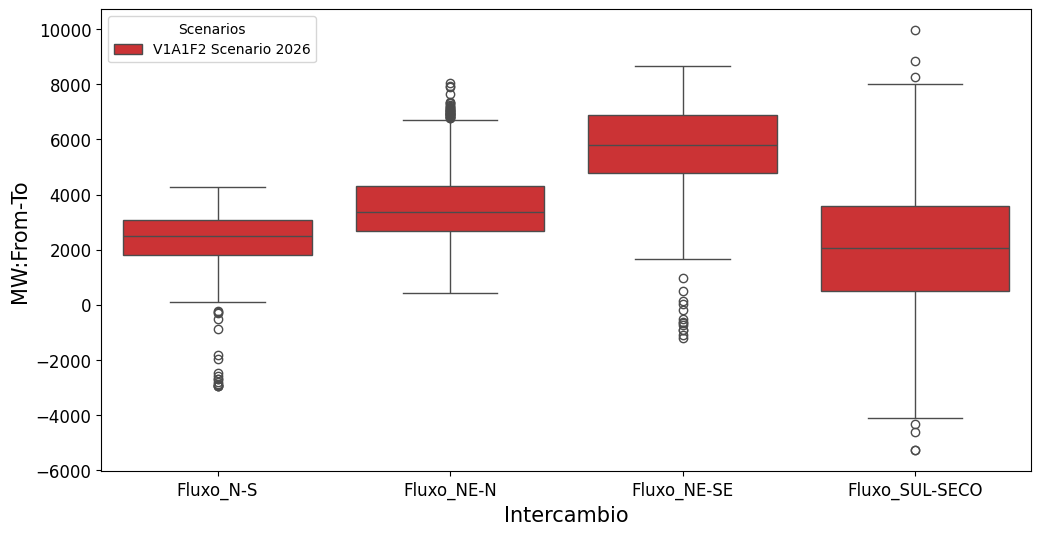

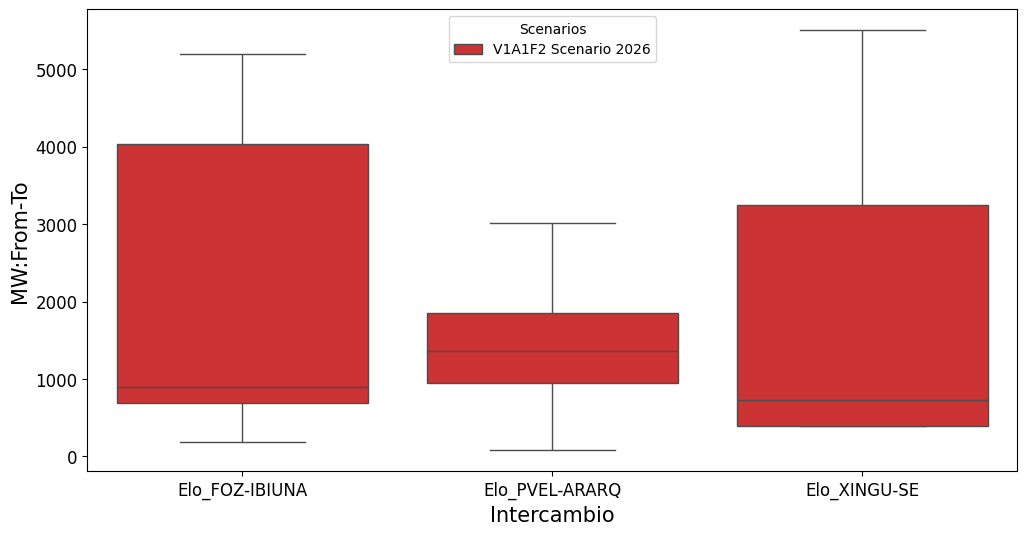

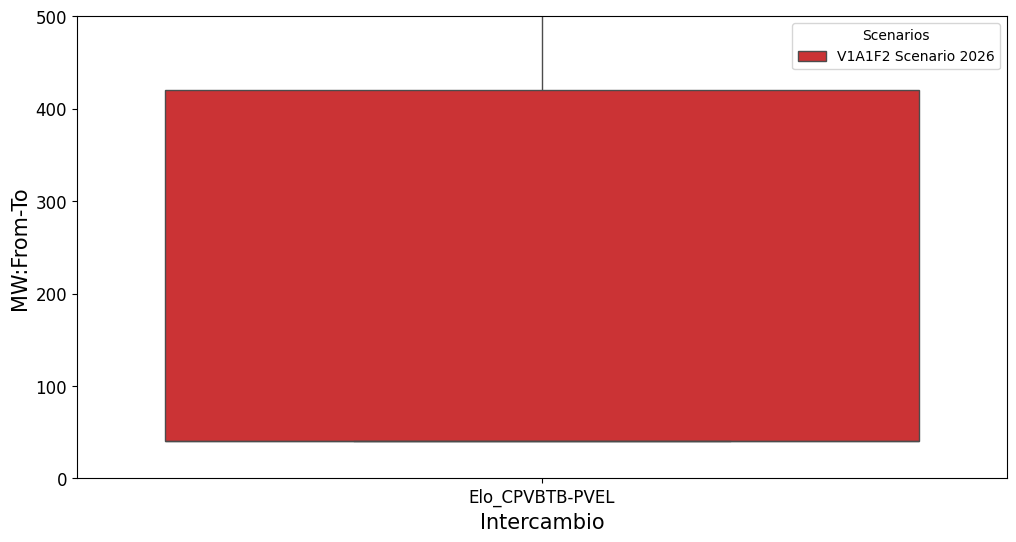

In [13]:
if Analise_Inter_HVDC:
    df_1 = DATA['df_Inter_AC_DC'].reset_index().melt(id_vars=['Dia', 'Hora', 'Cenario'], var_name='Intercambio', value_name='Value')
    df_fluxos_AC = df_1[df_1['Intercambio'].isin(['Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO'])]
    boxplot_linhas(df_fluxos_AC, 'Intercambio', 'Value' , '', 'Intercambio', 'MW:From-To', ylim = None)
    df_fluxos_DC = df_1[df_1['Intercambio'].isin(['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])]
    boxplot_linhas(df_fluxos_DC, 'Intercambio', 'Value' , '', 'Intercambio', 'MW:From-To', ylim = None)
    boxplot_linhas(df_1[df_1['Intercambio']=='Elo_CPVBTB-PVEL'], 'Intercambio', 'Value' , '', 'Intercambio', 'MW:From-To', ylim = [0,500])

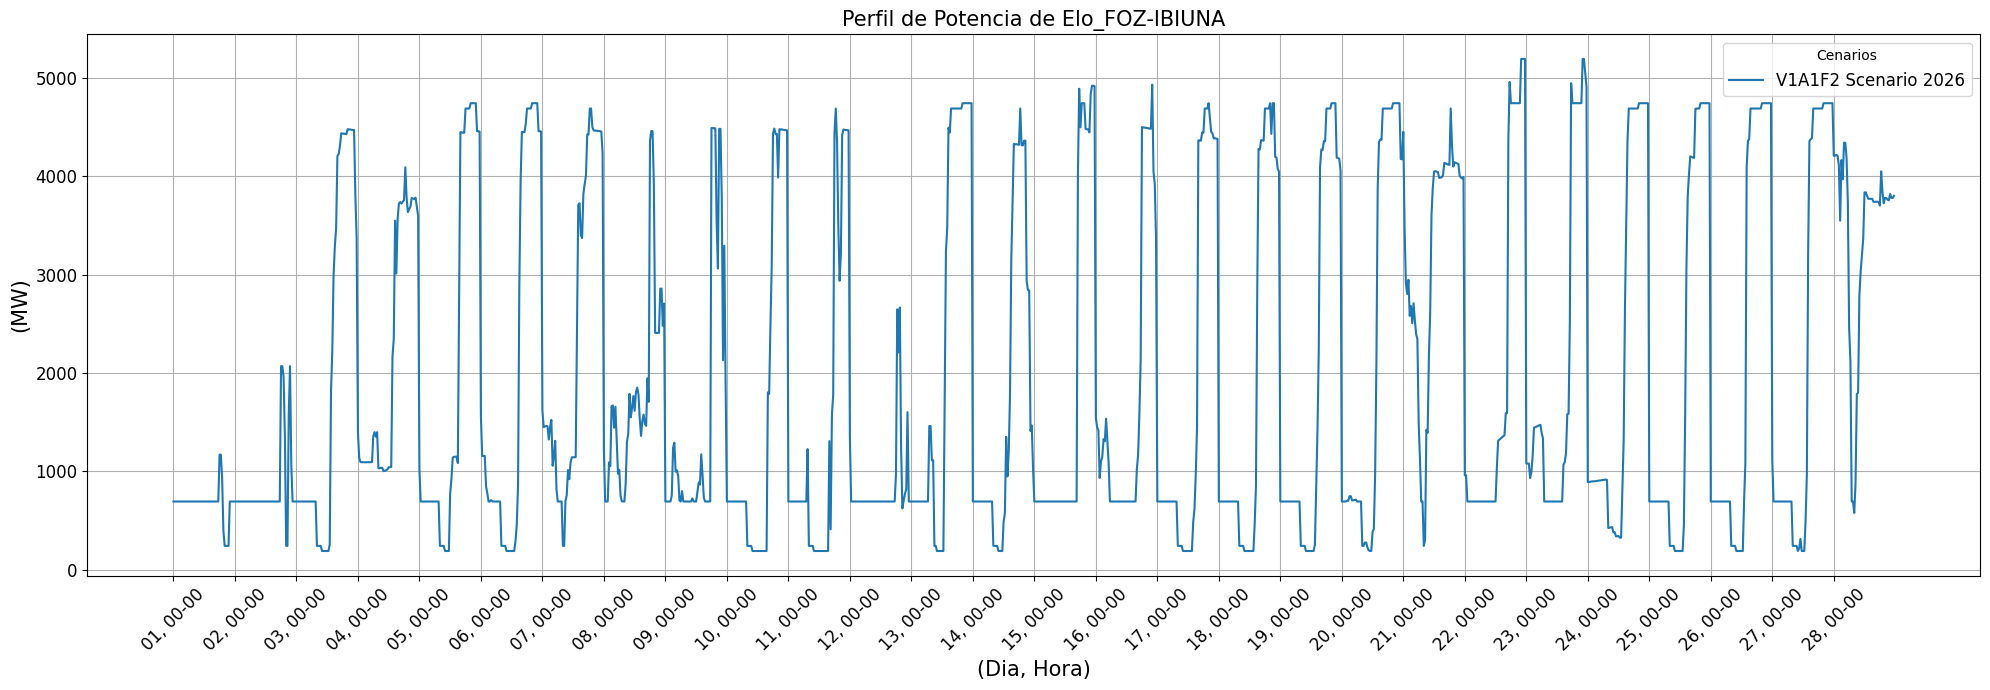

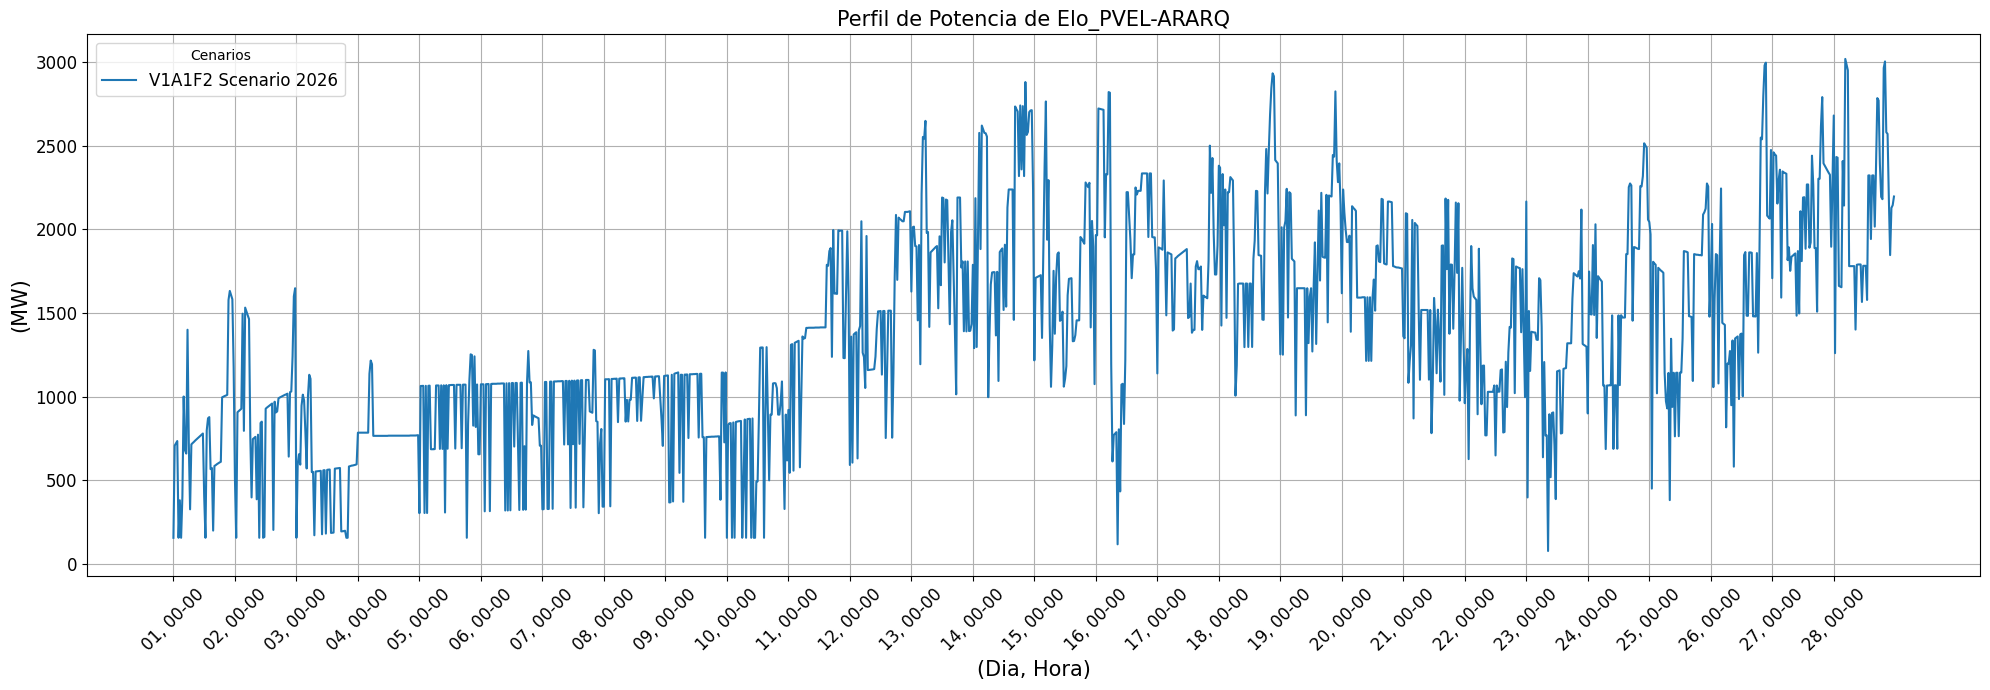

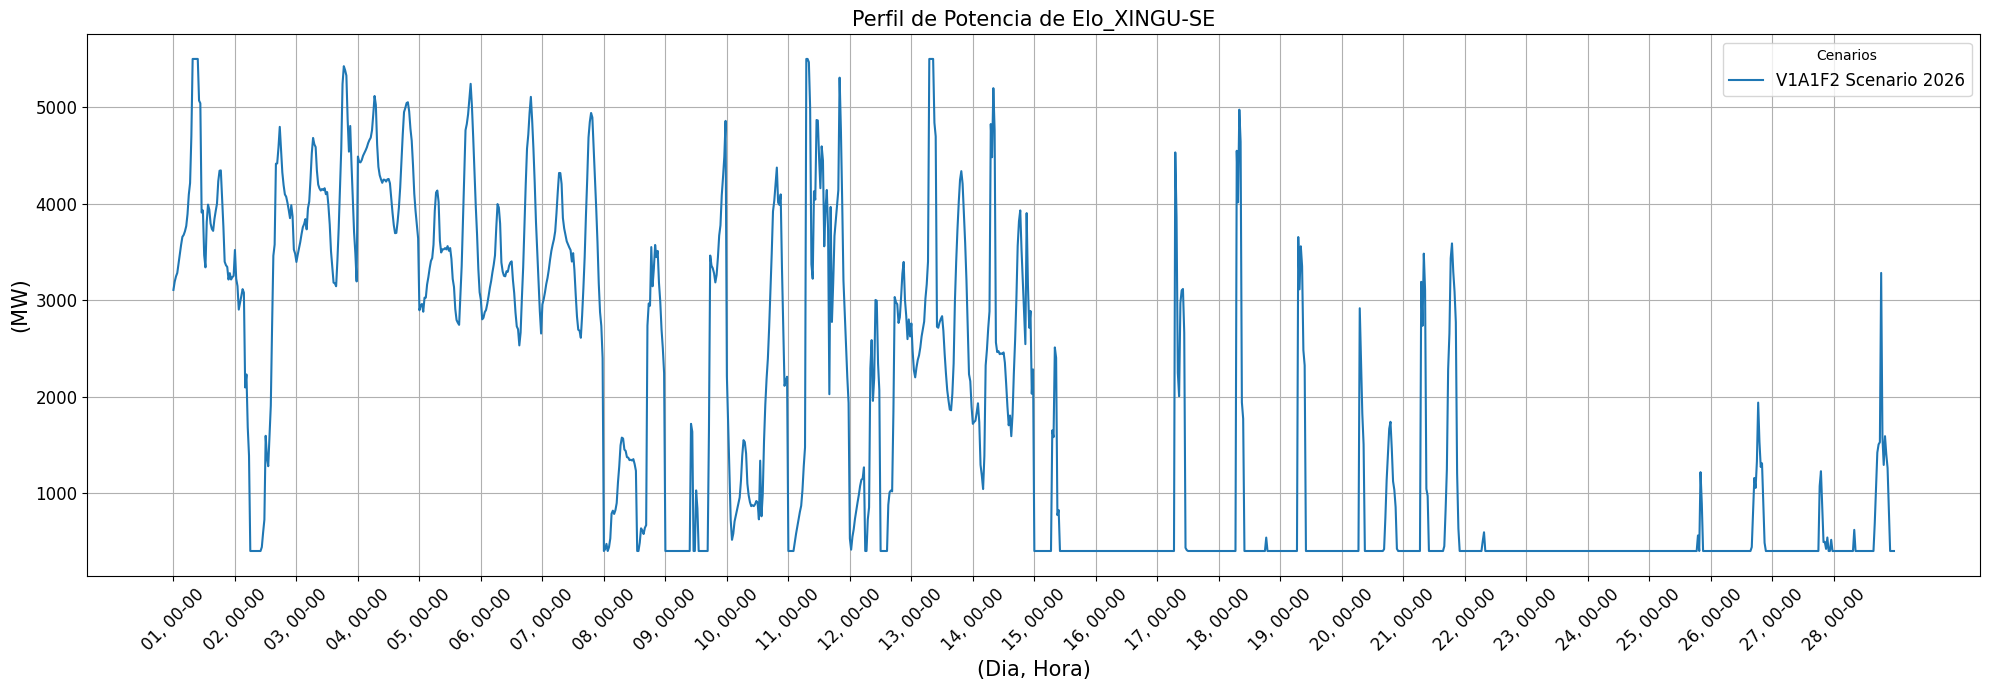

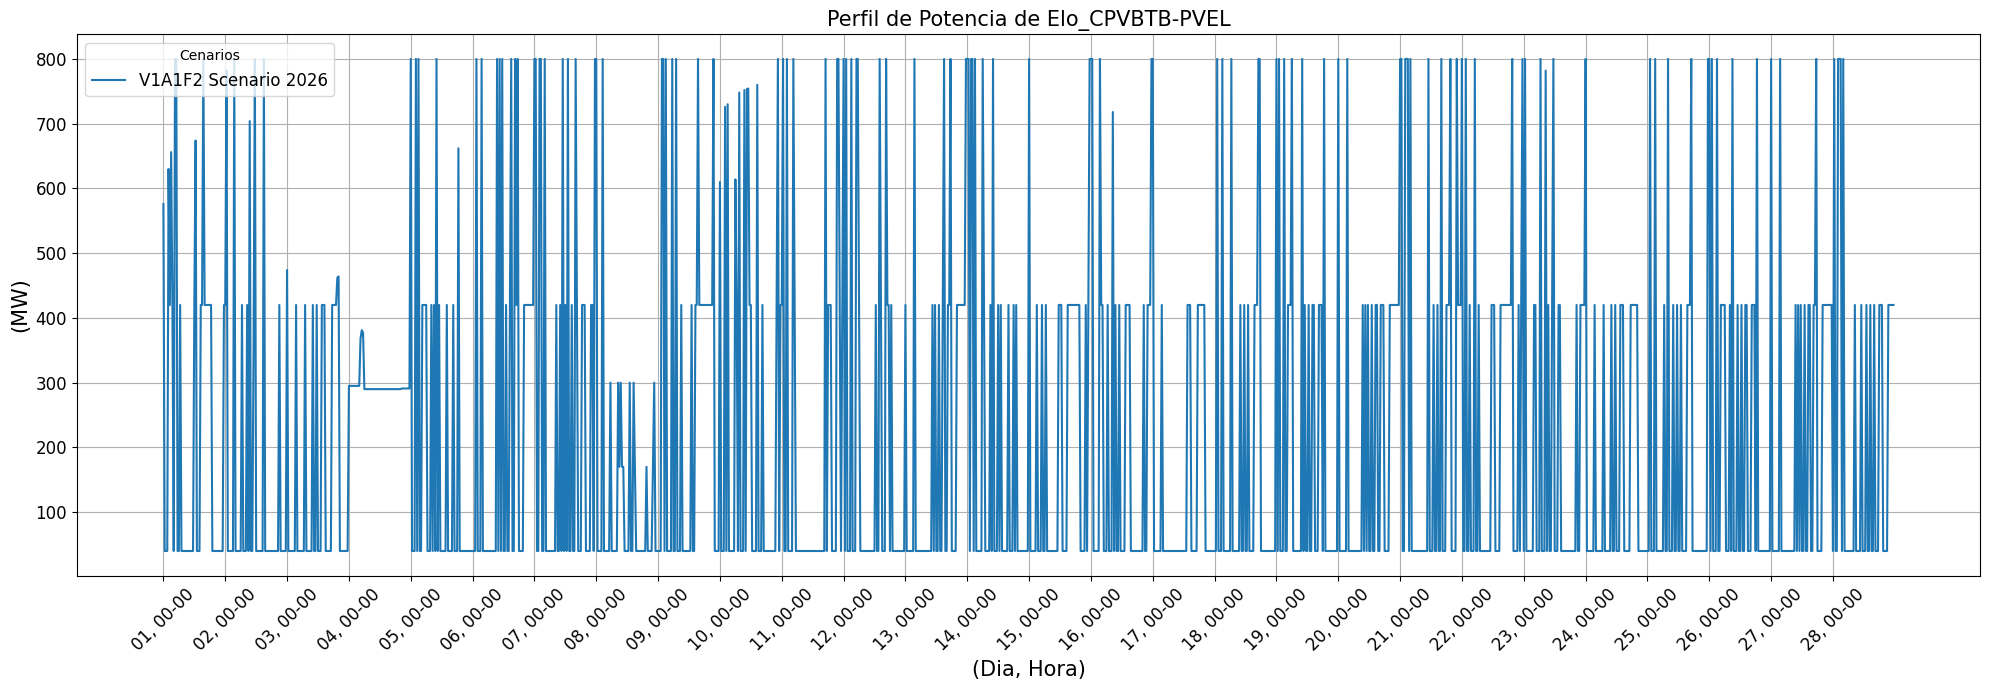

In [14]:
def plot_potencia_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

    df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
    plt.figure(figsize=(20, 7))
    sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', style='Cenario', markers=markers)
    plt.xlabel('(Dia, Hora)', fontsize = 15)
    plt.ylabel('(MW)', fontsize = 15)
    if column == 'DemandaLiquida':
        plt.title(f'Demanda Liquida Total do Sistema', fontsize = 15)
    else:
        plt.title(f'Perfil de Potencia de {column}', fontsize = 15)

    value = int(df['Dia_Hora'].unique().shape[0]/(28))
    selected_ticks = df['Dia_Hora'].iloc[::value]  # Change the step value as needed
    
    plt.xticks(selected_ticks, rotation=45, fontsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend(title='Cenarios', fontsize = 12)
    if ylim != None:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.grid()
    plt.show()

plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_FOZ-IBIUNA', markers=False)
plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_PVEL-ARARQ', markers=False)
plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_XINGU-SE', markers=False)
plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_CPVBTB-PVEL', markers=False)

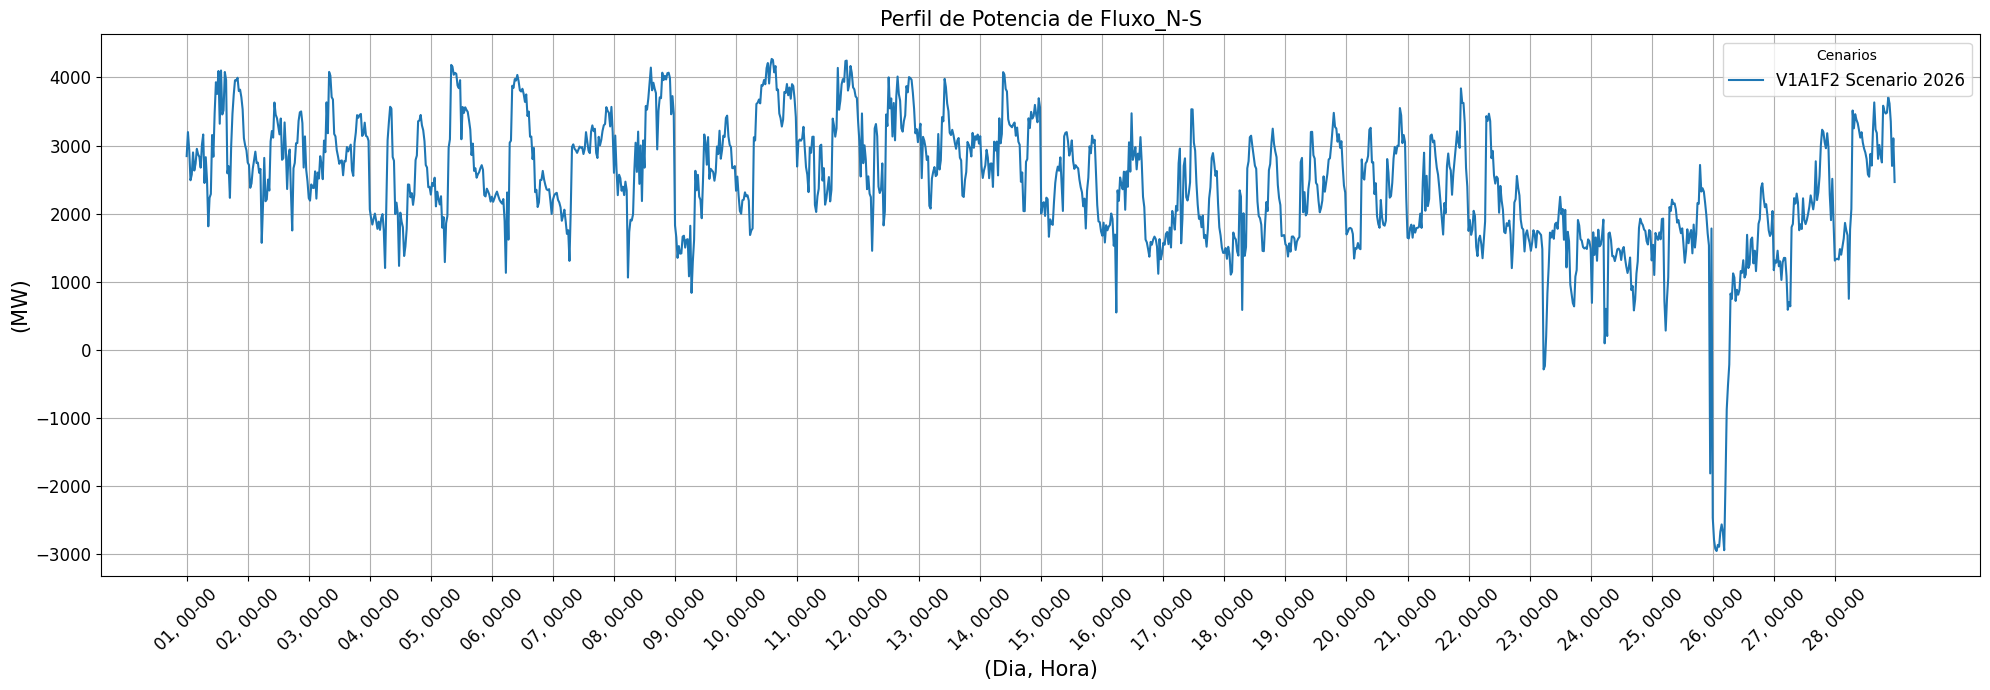

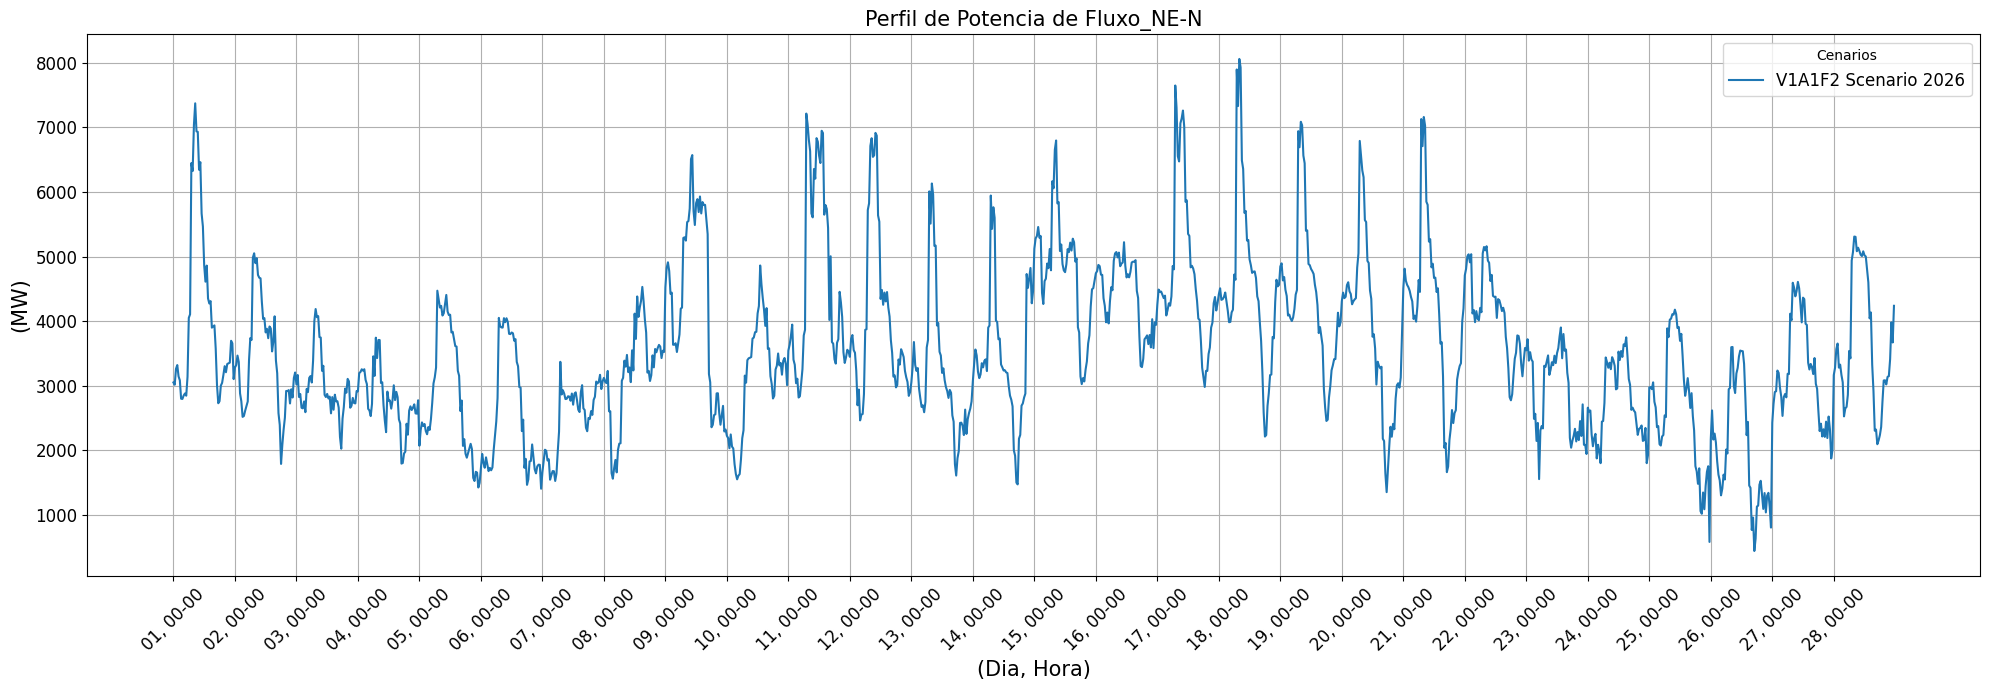

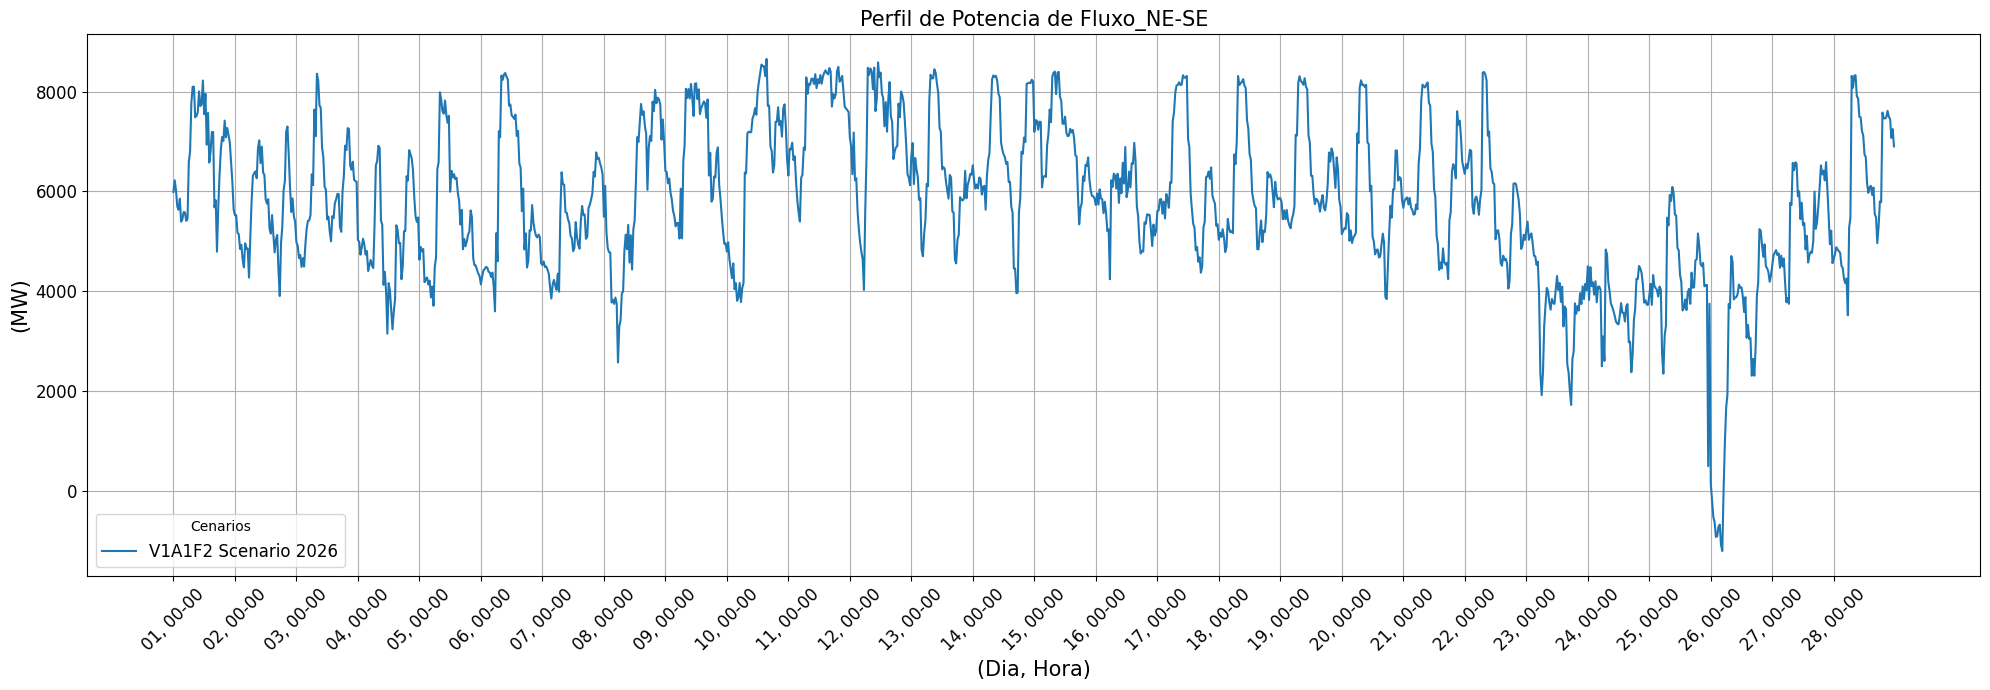

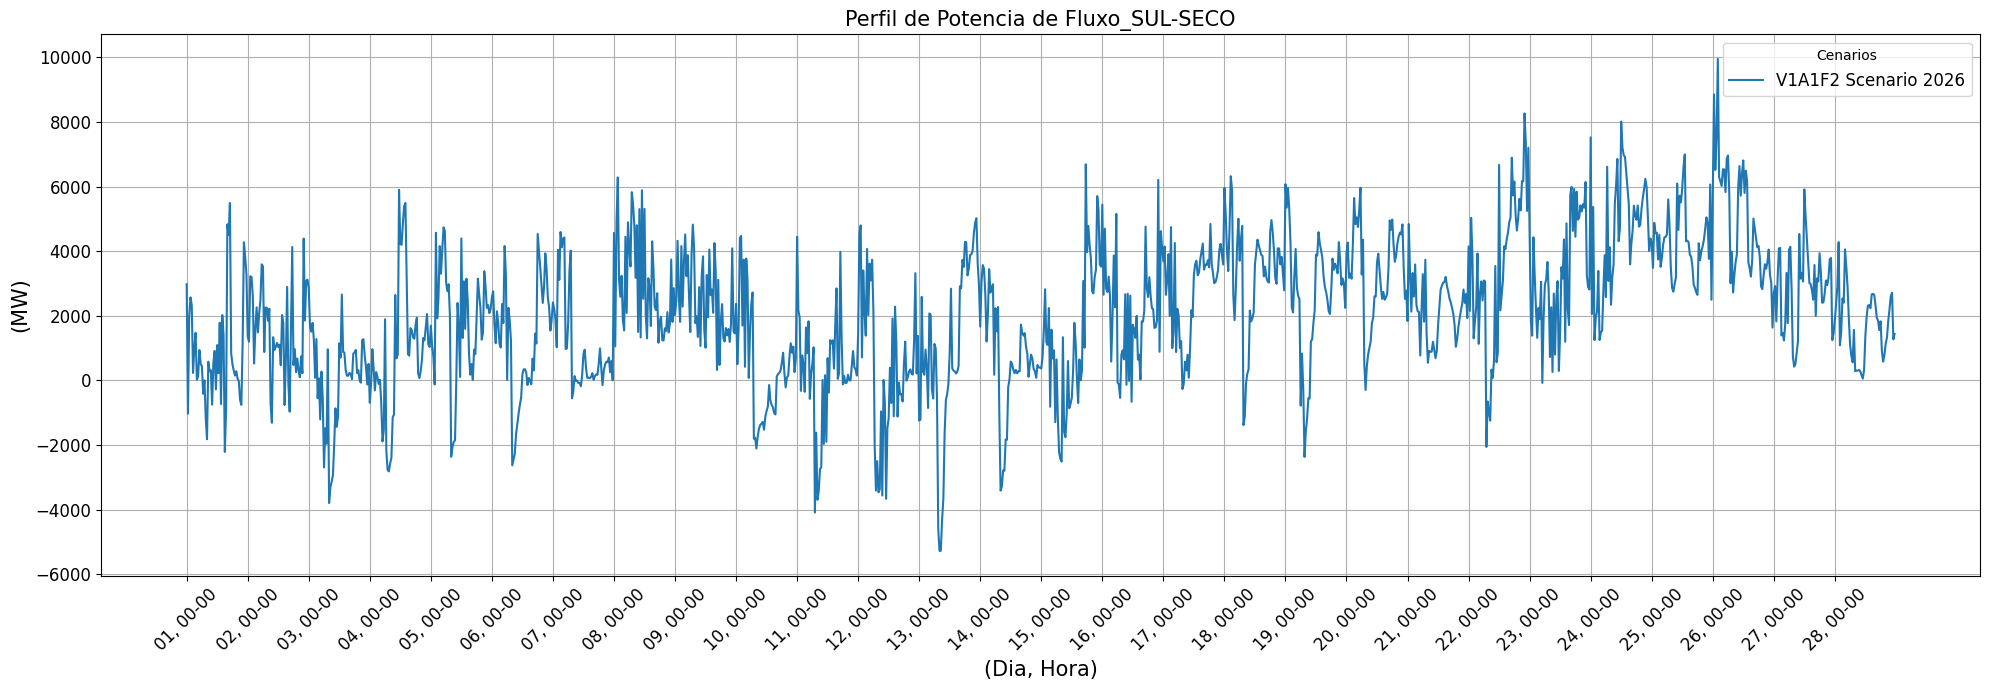

In [15]:
plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_N-S', markers=False)
plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_NE-N', markers=False)
plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_NE-SE', markers=False)
plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_SUL-SECO', markers=False)

In [16]:
fluxoONS = pd.read_csv("C:/Users/David/OneDrive/Documents/FERV_documentos/fluxo_intercambio_NORUS_2022/fluxo_intercambio/fluxo_intercambio_FNS.csv", sep=';')
# fluxoONS = pd.read_csv("C:/Users/David/OneDrive/Documents/FERV_documentos/fluxo_intercambio_NORUS_2026_V1A1F2_FNS_lim/fluxo_intercambio_FNS.csv", sep=';')

fluxoONS = fluxoONS.drop(fluxoONS.columns[0], axis=1)
fluxoONS = fluxoONS.drop(fluxoONS.columns[0], axis=1)
fluxoONS = fluxoONS.rename(columns={'periodo': 'Dia', 'hora': 'Hora', 'MW':'Fluxo_N-S_DESSEM'})
fluxoONS['Hora'] = fluxoONS['Hora'].str.replace(':','-')
fluxoONS['Dia'] = fluxoONS['Dia'].str.slice(0, 2)
fluxoONS = fluxoONS.melt(id_vars=['Dia','Hora'], value_vars='Fluxo_N-S_DESSEMS', var_name='Intercambio', value_name='Value').set_index(['Dia','Hora','Intercambio'])

df_1['Dia'] = df_1['Dia'].astype(str)
df_1['Dia'] = df_1['Dia'].str.zfill(2)
intercambio_previsto = df_1.set_index(['Dia', 'Hora','Intercambio']).drop(columns='Cenario')

df_compare_fluxs = pd.concat([fluxoONS,intercambio_previsto],axis = 0).reset_index()
df_compare_fluxs['Dia'] = df_compare_fluxs['Dia'].astype(str)
df_compare_fluxs['Dia_Hora'] = '(' + df_compare_fluxs['Dia'] + ', ' + df_compare_fluxs['Hora'] + ')'

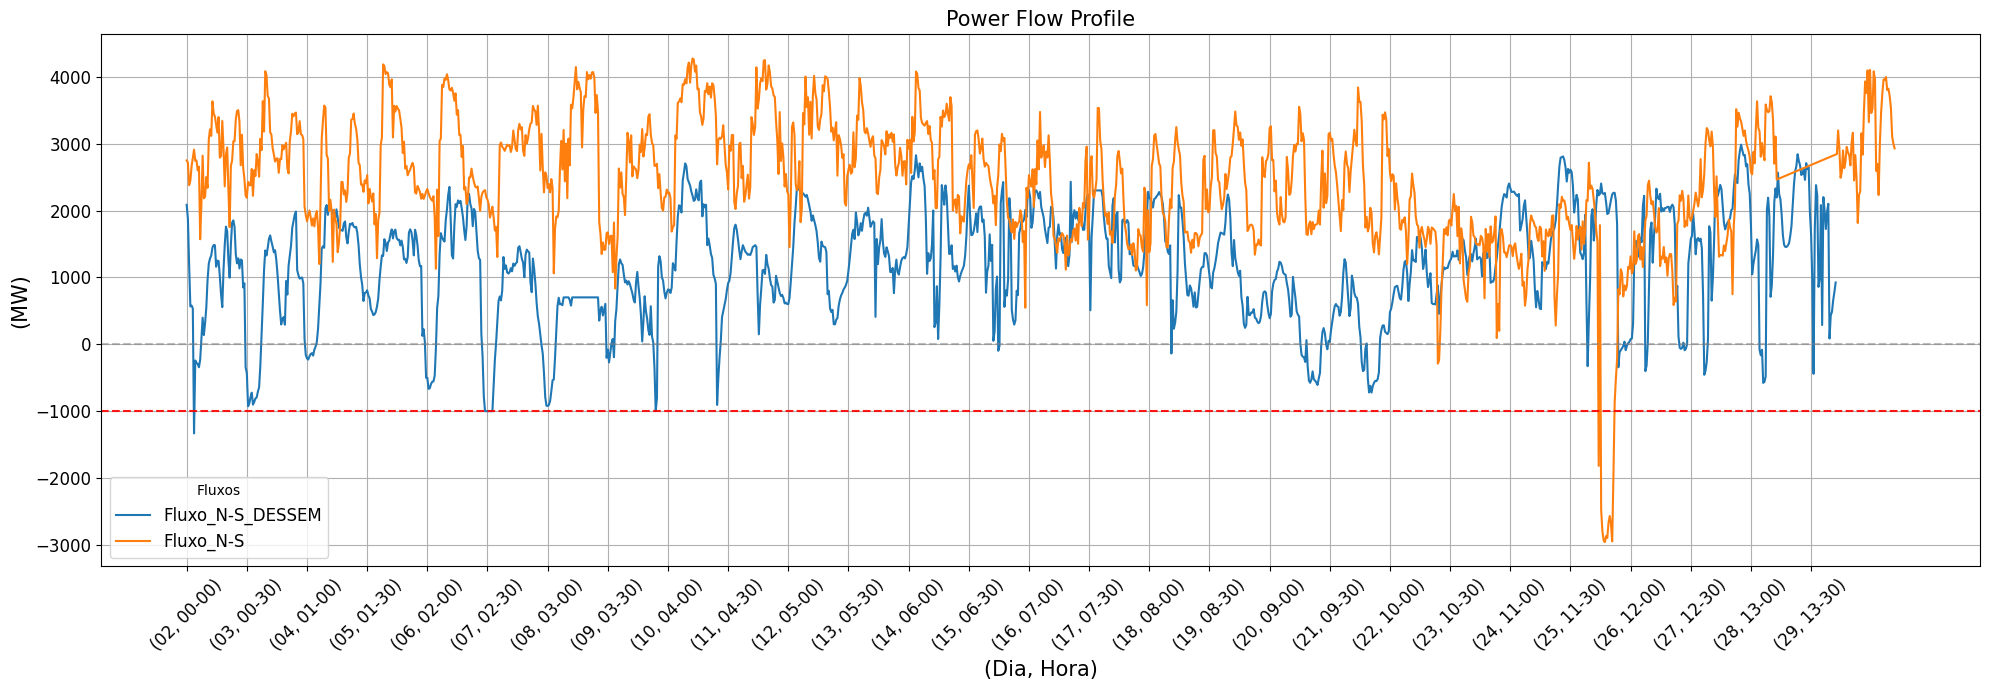

In [17]:
df = df_compare_fluxs
condition = df['Intercambio'].isin(['Fluxo_N-S','Fluxo_N-S_DESSEM'])

# Plotting
plt.figure(figsize=(20, 7))
# sns.lineplot(data=F_ONS_melted, x='Dia_Hora', y='value', hue='Fluxos', style='Fluxos', markers=True)
sns.lineplot(data=df[condition], x='Dia_Hora', y='Value', hue='Intercambio', style=None, markers=False)
plt.xlabel('(Dia, Hora)', fontsize = 15)
plt.ylabel('(MW)', fontsize = 15)
plt.title('Power Flow Profile', fontsize = 15)
# Select only some ticks for display
value = int(df['Dia_Hora'].unique().shape[0]/28)
selected_ticks = df[df['Intercambio'] == df['Intercambio'].unique()[0]].iloc[::value]['Dia_Hora'] # Change the step value as needed
plt.xticks(selected_ticks, rotation=45, fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(title='Fluxos', fontsize = 12)
# Agregar la línea horizontal en el valor cero del eje y
plt.axhline(0, color='gray', linestyle='--' ,  alpha=0.5)
plt.axhline(-1000, color='red', linestyle='--' ,  alpha=0.9)

plt.tight_layout()
plt.grid()
plt.show()